In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Packages used for specific tasks:

# "A diagram to illustrate the configuration of your array":
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from collections import OrderedDict

In [2]:
# Define speed of light 'c'
c    = 299792458.

# observation frequency 'freq' as defined in task, subsequently wavelength 'wvln'
freq = 5.0E+9
wvln = c/freq

# 1. Illustrating Array Configuration

Begin by fetching antenna positions for the VLA's D-configuration from external files. Data from 'An introduction to the NRAO Very Large Array' (https://library.nrao.edu/public/memos/vla/misc/VLAU_20.pdf; accessed September 2019).

The NRAO provides this data in units of nanoseconds (at the speed of light). For this section, it is more useful to store these positions in distance units.

In [3]:
# Assign positions to arrays for each arm - this is useful for readability in the diagram

arm_SW_ns = np.loadtxt('arm_SW.txt')[:,0:3]
arm_SE_ns = np.loadtxt('arm_SE.txt')[:,0:3]
arm_N_ns  = np.loadtxt('arm_N.txt')[:,0:3]

# Data is provided in nanoseconds (of lightspeed travel)
# Convert to distance in meters using speed of light as defined above

arm_SW = c * arm_SW_ns/(1.E+9)
arm_SE = c * arm_SE_ns/(1.E+9)
arm_N  = c *  arm_N_ns/(1.E+9)

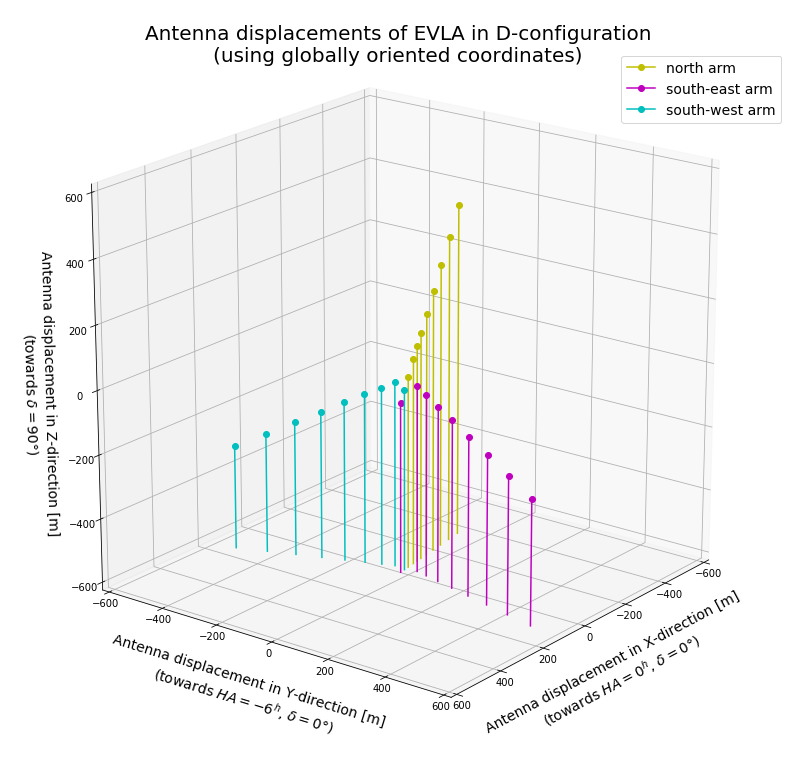

In [4]:
# Create figure displaying 3d plot of VLA in D-config using antenna positions from above
# Use 'Axes3D' from matplotlib toolkit 'mplot3d' to set " projection='3d' "

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

x = 600   # limit of plot in meters

# Begin by adding vertical lines to each point to aid comprehension of 3d distribution
# Use 'art3d' from matplotlib toolkit 'mplot3d' to create Line3D objects

for xi, yi, zi in zip(arm_N[:,0], arm_N[:,1], arm_N[:,2]):        
    line=art3d.Line3D(*zip((xi, yi, -x), (xi, yi, zi)), c='y', marker='o', markevery=(1, 1),label='north arm')
    ax.add_line(line)
for xi, yi, zi in zip(arm_SE[:,0], arm_SE[:,1], arm_SE[:,2]):        
    line=art3d.Line3D(*zip((xi, yi, -x), (xi, yi, zi)), c='m', marker='o', markevery=(1, 1),label='south-east arm')
    ax.add_line(line)
for xi, yi, zi in zip(arm_SW[:,0], arm_SW[:,1], arm_SW[:,2]):        
    line=art3d.Line3D(*zip((xi, yi, -x), (xi, yi, zi)), c='c', marker='o', markevery=(1, 1),label='south-west arm')
    ax.add_line(line)

# Set 3d plot limits

ax.set_xlim(-x,x)
ax.set_ylim(-x,x)
ax.set_zlim(-x,x)

# Plot formatting

ax.set_title('Antenna displacements of EVLA in D-configuration\n(using globally oriented coordinates)',fontsize=20)
ax.set_xlabel('Antenna displacement in X-direction [m]\n(towards $HA=0^h$, $δ=0°$)',fontsize=14,labelpad=16)
ax.set_ylabel('Antenna displacement in Y-direction [m]\n(towards $HA={-6}^h$, $δ=0°$)',fontsize=14,labelpad=16)
ax.set_zlabel('Antenna displacement in Z-direction [m]\n(towards $δ=90°$)',fontsize=14,labelpad=16)
ax.tick_params(axis='x',pad=-3)
ax.tick_params(axis='y',pad=-3)

# Create OrderedDict object to control legend ordering

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 0.945), prop={'size': 14})

ax.view_init(20, 37.5)
plt.draw()


###### Fig. 1: The VLA in D-Configuration oriented in global coordinates. The reference frame uses the Earth's rotation axis as its z-axis, and the y-direction points radially outwards from the longitudinal position of the VLA.

By converting the supplied VLA antenna positions from the NRAO, the layout of the antennas is displayed in D-configuration.


***


# 2. Diagram to Show UV Coverage

We begin by defining the 'pairings' function: given a list of items, 'pairings' returns every possible unique pairing of items, where ordering does not matter (i.e. for list [a,b,c,d,e]: [a,b] is equivalent to [b,a], [a,a] is prohibited). The pairs returned are:

|   | a | b | c | d | e |
|---|---|---|---|---|---|
| a |   | • | • | • | • |
| b |   |   | • | • | • |
| c |   |   |   | • | • |
| d |   |   |   |   | • |
| e |   |   |   |   |   |

Each pair is stored along with a label specifying the pair of telescopes which constitute the pair.

We can then create a list of all possible pairs of the 27 telescopes in the array by storing the xyz coordinates of the two dishes. Additionally, a list of the 351 baseline lengths is also stored.

In [5]:
def pairings(inp):
    result = []
    for m in range(len(inp)):
        for n in range(m+1,len(inp)):
            result.append([m,n,inp[m],inp[n]])
    return result

# Create list of telescope pairs

# Each item in initial list is 3-dimensional coordinate, thus list is pairs of 3D coordinates

pairs = np.array(pairings(np.concatenate((arm_SW,arm_SE,arm_N))))

# Create list of baseline lengths - also store label for pair as before

baselines = []
for i in range(len(pairs)):
    baselines.append([pairs[i][0],pairs[i][1],
                         np.sqrt((pairs[i][2]-pairs[i][3])[0]**2
                               + (pairs[i][2]-pairs[i][3])[1]**2
                               + (pairs[i][2]-pairs[i][3])[2]**2)])
baselines = np.array(baselines)

We will create lists of 'u'- and 'v'-points, with each baseline's contribution stored in a separate sub-array. This will enable each baseline to be accessed separately later.

In [6]:
u=[]
v=[]
for baseline in baselines:
    u.append([])
    v.append([])

# Create space for the two antenna IDs to be stored

u = [[],[],u]
v = [[],[],v]

H0 and d0 are the coordinates of the 'phase reference position' (the center of the observing field) at each timestep:
- H0 is the hour angle of this position, which changes with time
- d0 is the declination, which is constant

For each baseline, we iterate over the 121 observing points, storing the UV displacement - in units of wavelengths - of the two vectors defined by the given baseline (one in each direction).

Plotting all of the UV points, for each baseline and each observation, together gives us the UV coverage achieved during the entire observing period.

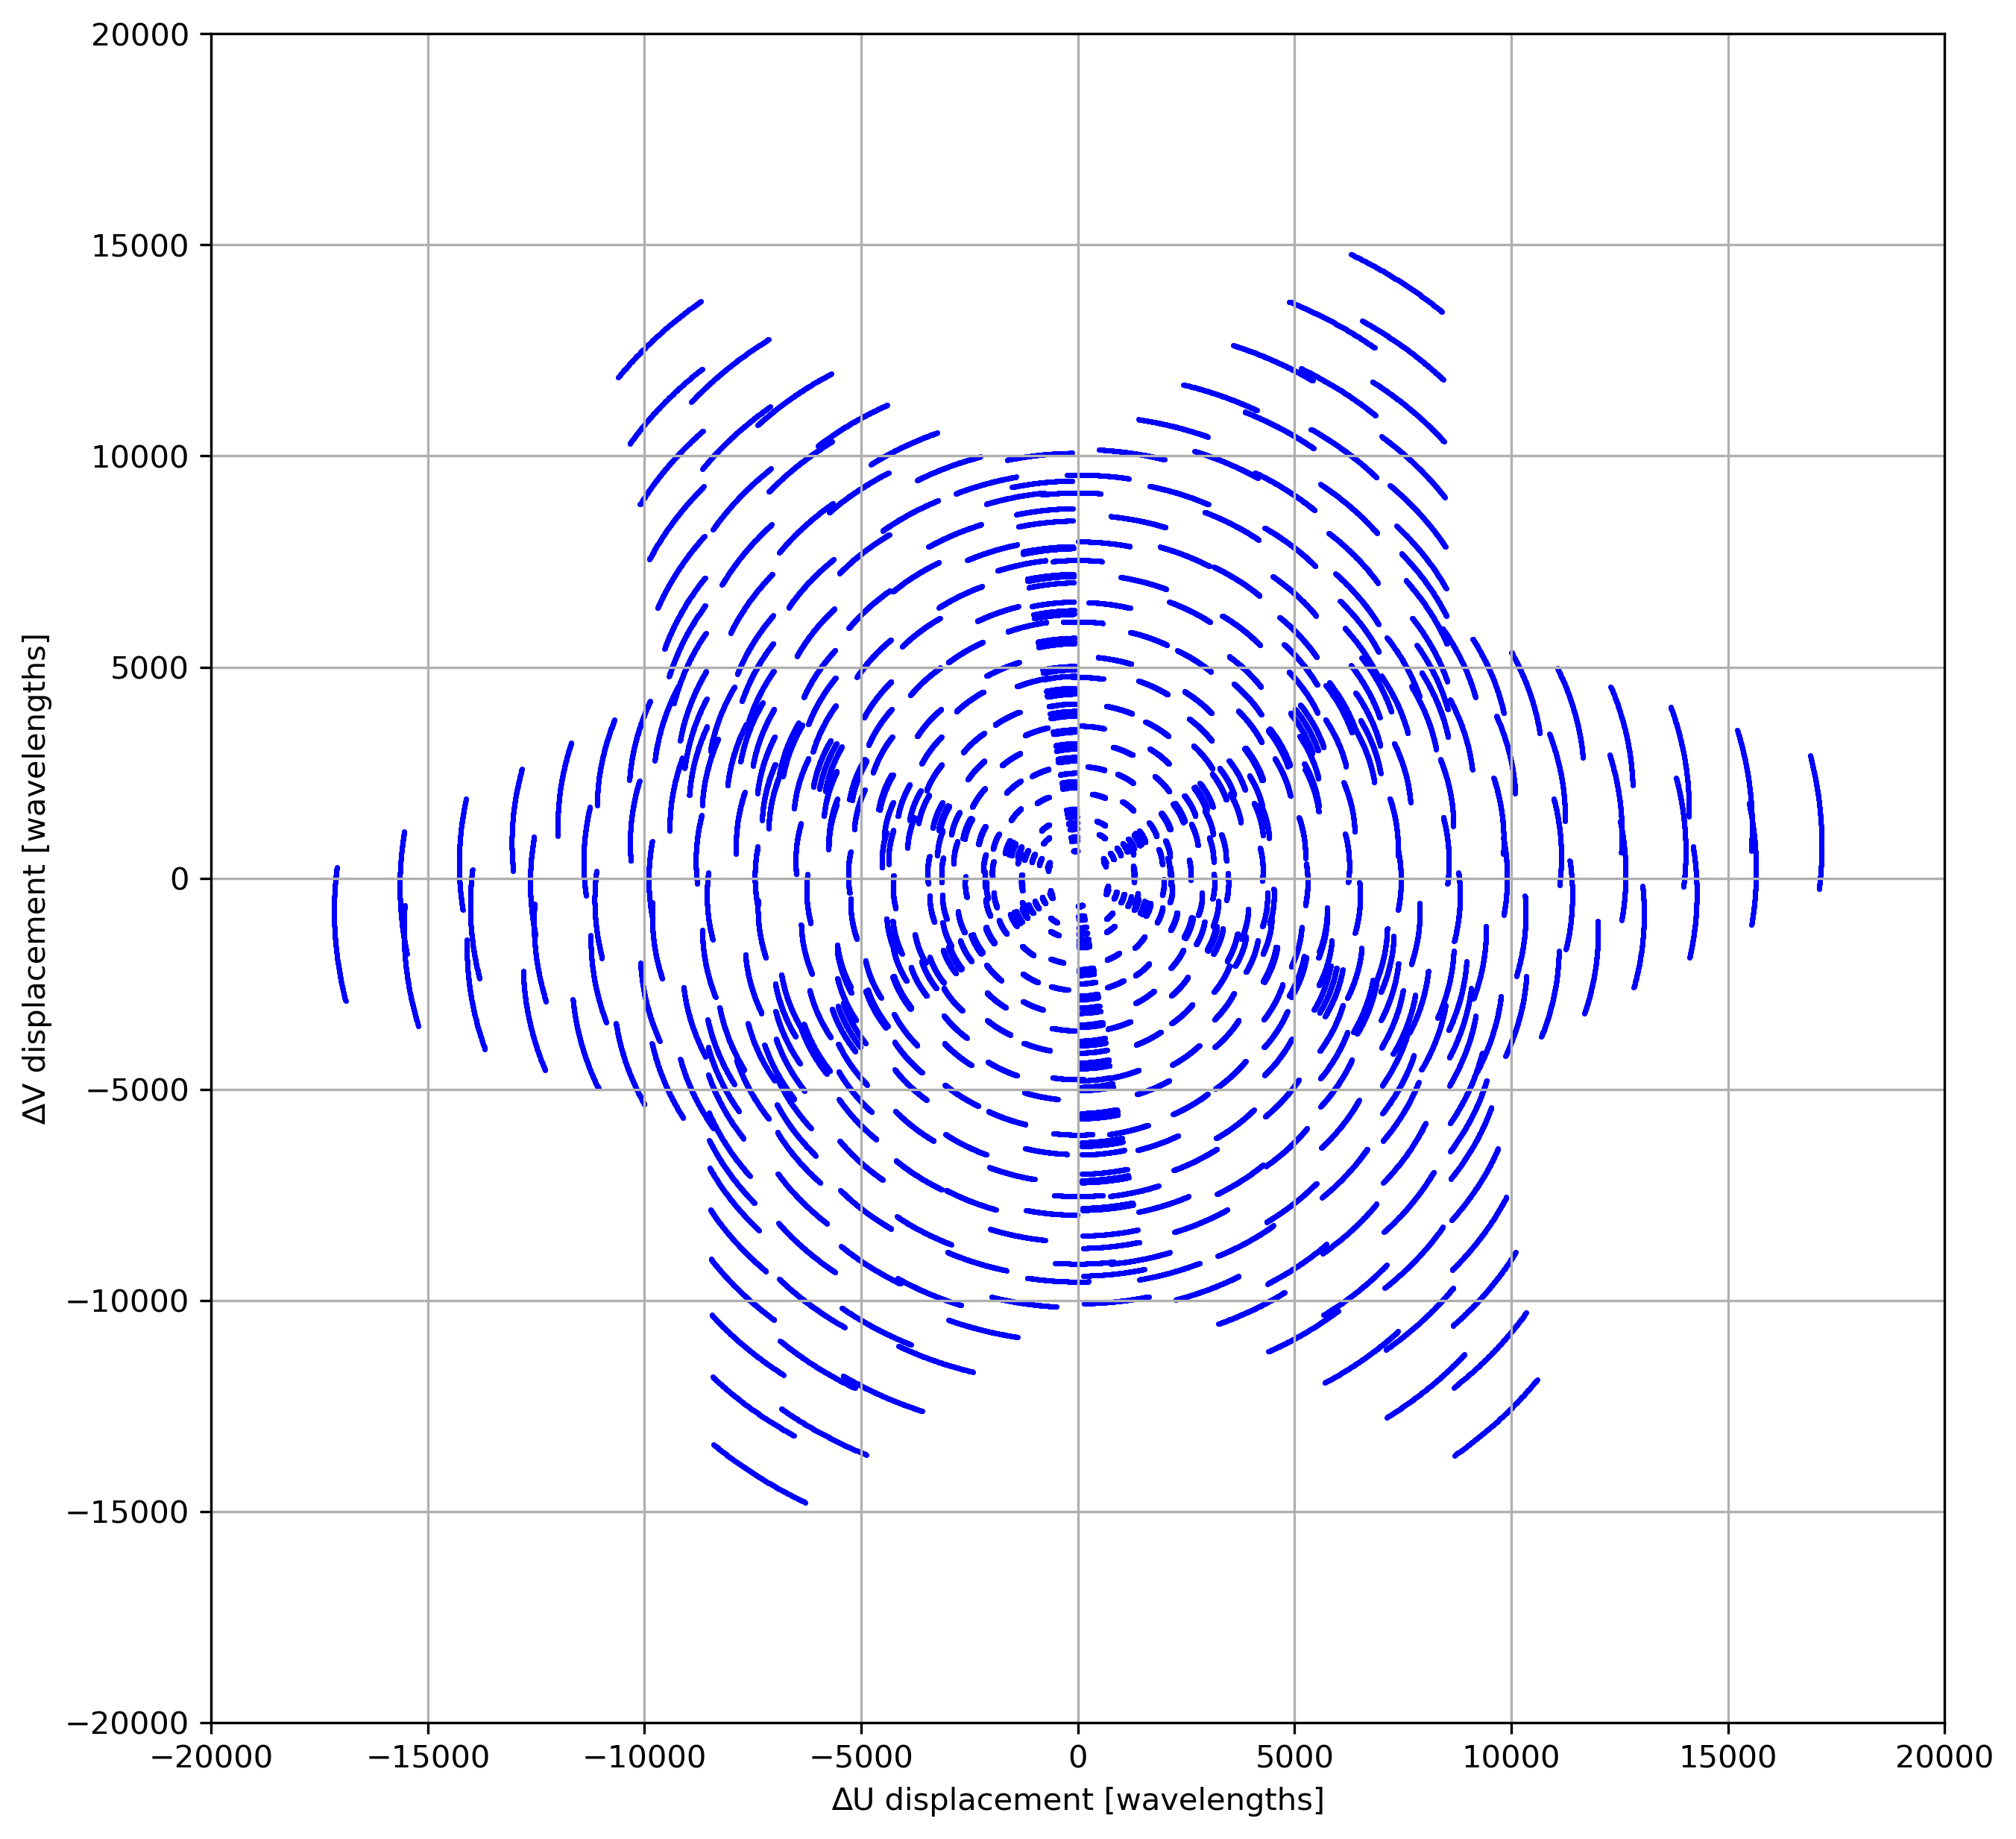

In [7]:
# Define declination d0 in radians

d0 = np.pi/4.

# Observations are carried out every 30 seconds over the period ± 0.5 hours of culmination
# i.e. 121 observations in total

# Entire circle is 24h and 2pi radians, so multiply by pi/12 to convert from hours to radians

obs = (np.pi/12.)*np.linspace(-0.5,0.5,121) # units of hours

# Iterate over all baselines (i.e. telescope pairs)

for i in range(len(pairs)):
    # Each baseline contributes two uv vectors (one in each direction)
    Lx,  Ly,  Lz  = pairs[i][3] - pairs[i][2]
    Lx_, Ly_, Lz_ = pairs[i][2] - pairs[i][3]
    
    # Store pair of antenna IDs for each baseline
    
    u[0].append(pairs[i][0])
    v[0].append(pairs[i][0])
    
    u[1].append(pairs[i][1])
    v[1].append(pairs[i][1])
    
    # Iterate over the 121 'observations'
    
    for H0 in obs:
        
        # Calculate ∆u, ∆v from x,y,z displacements and scale for wavelength
        # Uses equation 4.1 from 'Interferometry and Synthesis in Radio Astronomy, Third Edition'
        # (Thompson, Moran & Swenson 2017)
        
        # Append ∆u and ∆v for both vector directions to u- and v-point arrays
        
        u[2][i].append((1/wvln)*(np.sin(H0)*Lx + np.cos(H0)*Ly))
        v[2][i].append((1/wvln)*(-np.sin(d0)*np.cos(H0)*Lx + np.sin(d0)*np.sin(H0)*Ly + np.cos(d0)*Lz))
        
        u[2][i].append((1/wvln)*(np.sin(H0)*Lx_ + np.cos(H0)*Ly_))
        v[2][i].append((1/wvln)*(-np.sin(d0)*np.cos(H0)*Lx_ + np.sin(d0)*np.sin(H0)*Ly_ + np.cos(d0)*Lz_))



# Plot uv tracks

plt.figure(figsize=(10,10),dpi=300)
plt.grid()
for i in range(len(pairs)):
    plt.scatter(u[2][i],v[2][i], c='b', s=0.5)
plt.xlim((-20000,20000))
plt.ylim((-20000,20000))
plt.xlabel('∆U displacement [wavelengths]')
plt.ylabel('∆V displacement [wavelengths]')
plt.show()

###### Fig. 2: The UV tracks swept out by the VLA over the 1-hour observation.


***


# 3. Creating the Input Field (i.e. the 'sky' seen by the telescope)

We must create a 2D array which stores the two point sources, which will be Fourier transformed to create the UV interference pattern which the interferometer probes.

We start by deciding the image side length in degrees, and pixel size in arcseconds. Other parameters of the image array, used for calculation, are derived from these two initial parameters. Crucially, the array dimensions are calculated at this point - it can be useful to start with two user-defined parameters which result in a nice number of pixels.

In [8]:
imagesize = 1.0 # side length of image in degrees
dims_arcsec = imagesize*3600 # Convert side length of image to arcseconds

pixelsize_arcsec = 0.5 # side length of pixels in arcseconds

# Use image size and pixel size in arcseconds to determine size of image array

dims = int(round(dims_arcsec/pixelsize_arcsec)) # pixel size of image

# Find image size in degrees to be used for plot labels

pixel_size_deg = imagesize/dims

# Create field array

field = np.zeros((dims,dims))

To help place the two point sources, the image array dimensions are first used to create astronomical coordinate labels for the cell boundaries.

To keep pixels square in terms of real angle values, image extent is muiltiplied by the square root of 2 in the right-ascension direction. This is because 'Real' angular distances in the RA direction have a factor of 1/cos(declination) compared to the change in RA coordinate.

Since the image will cover a relatively small range of declination, we can approximate this variable 1/cos(dec) factor to a constant 1/cos(45), or sqrt(2). This results in a deviation from real RA lengths of only 1% at 1 degree either side of 45 degree declination, and a negligible deviation in the region of the image where the two point sources will be located.

We can thus create 1D arrays which define the cell boundaries of the image array in astronomical coordinates.

In [9]:
# Assign astronomical coordinate values to cell boundaries (hence dims + 1) in the field

k = 0.5*imagesize

# To keep pixels square in terms of real angle values, image extent is muiltiplied by
# root 2 in the right-ascension direction

# 'Real' angular distances in the RA direction have a factor of 1/cos(declination)
# compared to the change in RA coordinate

# Since the image will cover a relatively small range of declination, approximate
# this 1/cos(dec) factor to 1/cos(45), or sqrt(2)

RA  = np.linspace(75.0 - k*np.sqrt(2.0),
                  75.0 + k*np.sqrt(2.0),
                  dims + 1)
dec = np.linspace(45.0 - k,
                  45.0 + k,
                  dims + 1)

The 1D arrays are referred to as the two point sources are placed into the array.

Thus, we create the 'sky' available to be observed by the VLA:

In [10]:
# Create point sources using given specifications
# Store information in array for each source (flux density, RA, dec)

ps_1 = [3.6,
        15.*(5.),
        (45.)]
ps_2 = [5.8,
        15.*(5. + 10/3600),
        (45. + 3/60)]

# Convert locations of point sources to pixel locations given extent of image array
# and size of pixels

ra1  = np.int(np.round((ps_1[1]-RA[0])/(np.sqrt(2)*pixel_size_deg)))
dec1 = np.int(np.round((ps_1[2]-dec[0])/pixel_size_deg))

ra2  = np.int(np.round((ps_2[1]- (75.-np.sqrt(2)*k))/(np.sqrt(2)*pixel_size_deg)))
dec2 = np.int(np.round((ps_2[2]-(45.-k))/pixel_size_deg))

# Change values of image array (sky or 'field') to those for the given point sources

field[dec1][ra1] = ps_1[0]
field[dec2][ra2] = ps_2[0]

The astronomical coordinate arrays are also useful for creating plot labels for displaying the sky. A code-based solution can be employed to generalise this to various zoom levels:

In [11]:
# For greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/5

# Create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)

lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

# Use the size of the zoomed-in area to create meaningful plot labels in astronomical coordinates

tickrange = window
tickspace_RA = (window)/6
tickspace_dec = (window)/8
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA  = []
ticklabels_dec = []
for i in range(len(ticks_RA)):
    ticklabels_RA.append(round(RA[lo+int(np.round(ticks_RA[i]))],2))
for i in range(len(ticks_dec)):
    ticklabels_dec.append(round(dec[lo+int(np.round(ticks_dec[i]))],3))

We can thus display the central region of the input field (using interpolation to make the point sources more visible) and apply astronomical coordinate labels for context. Even with interpolation and zooming in on the central region of the field, the high resolution can make the point sources difficult to see. To combat this, the two point sources are highlighted by circling them:

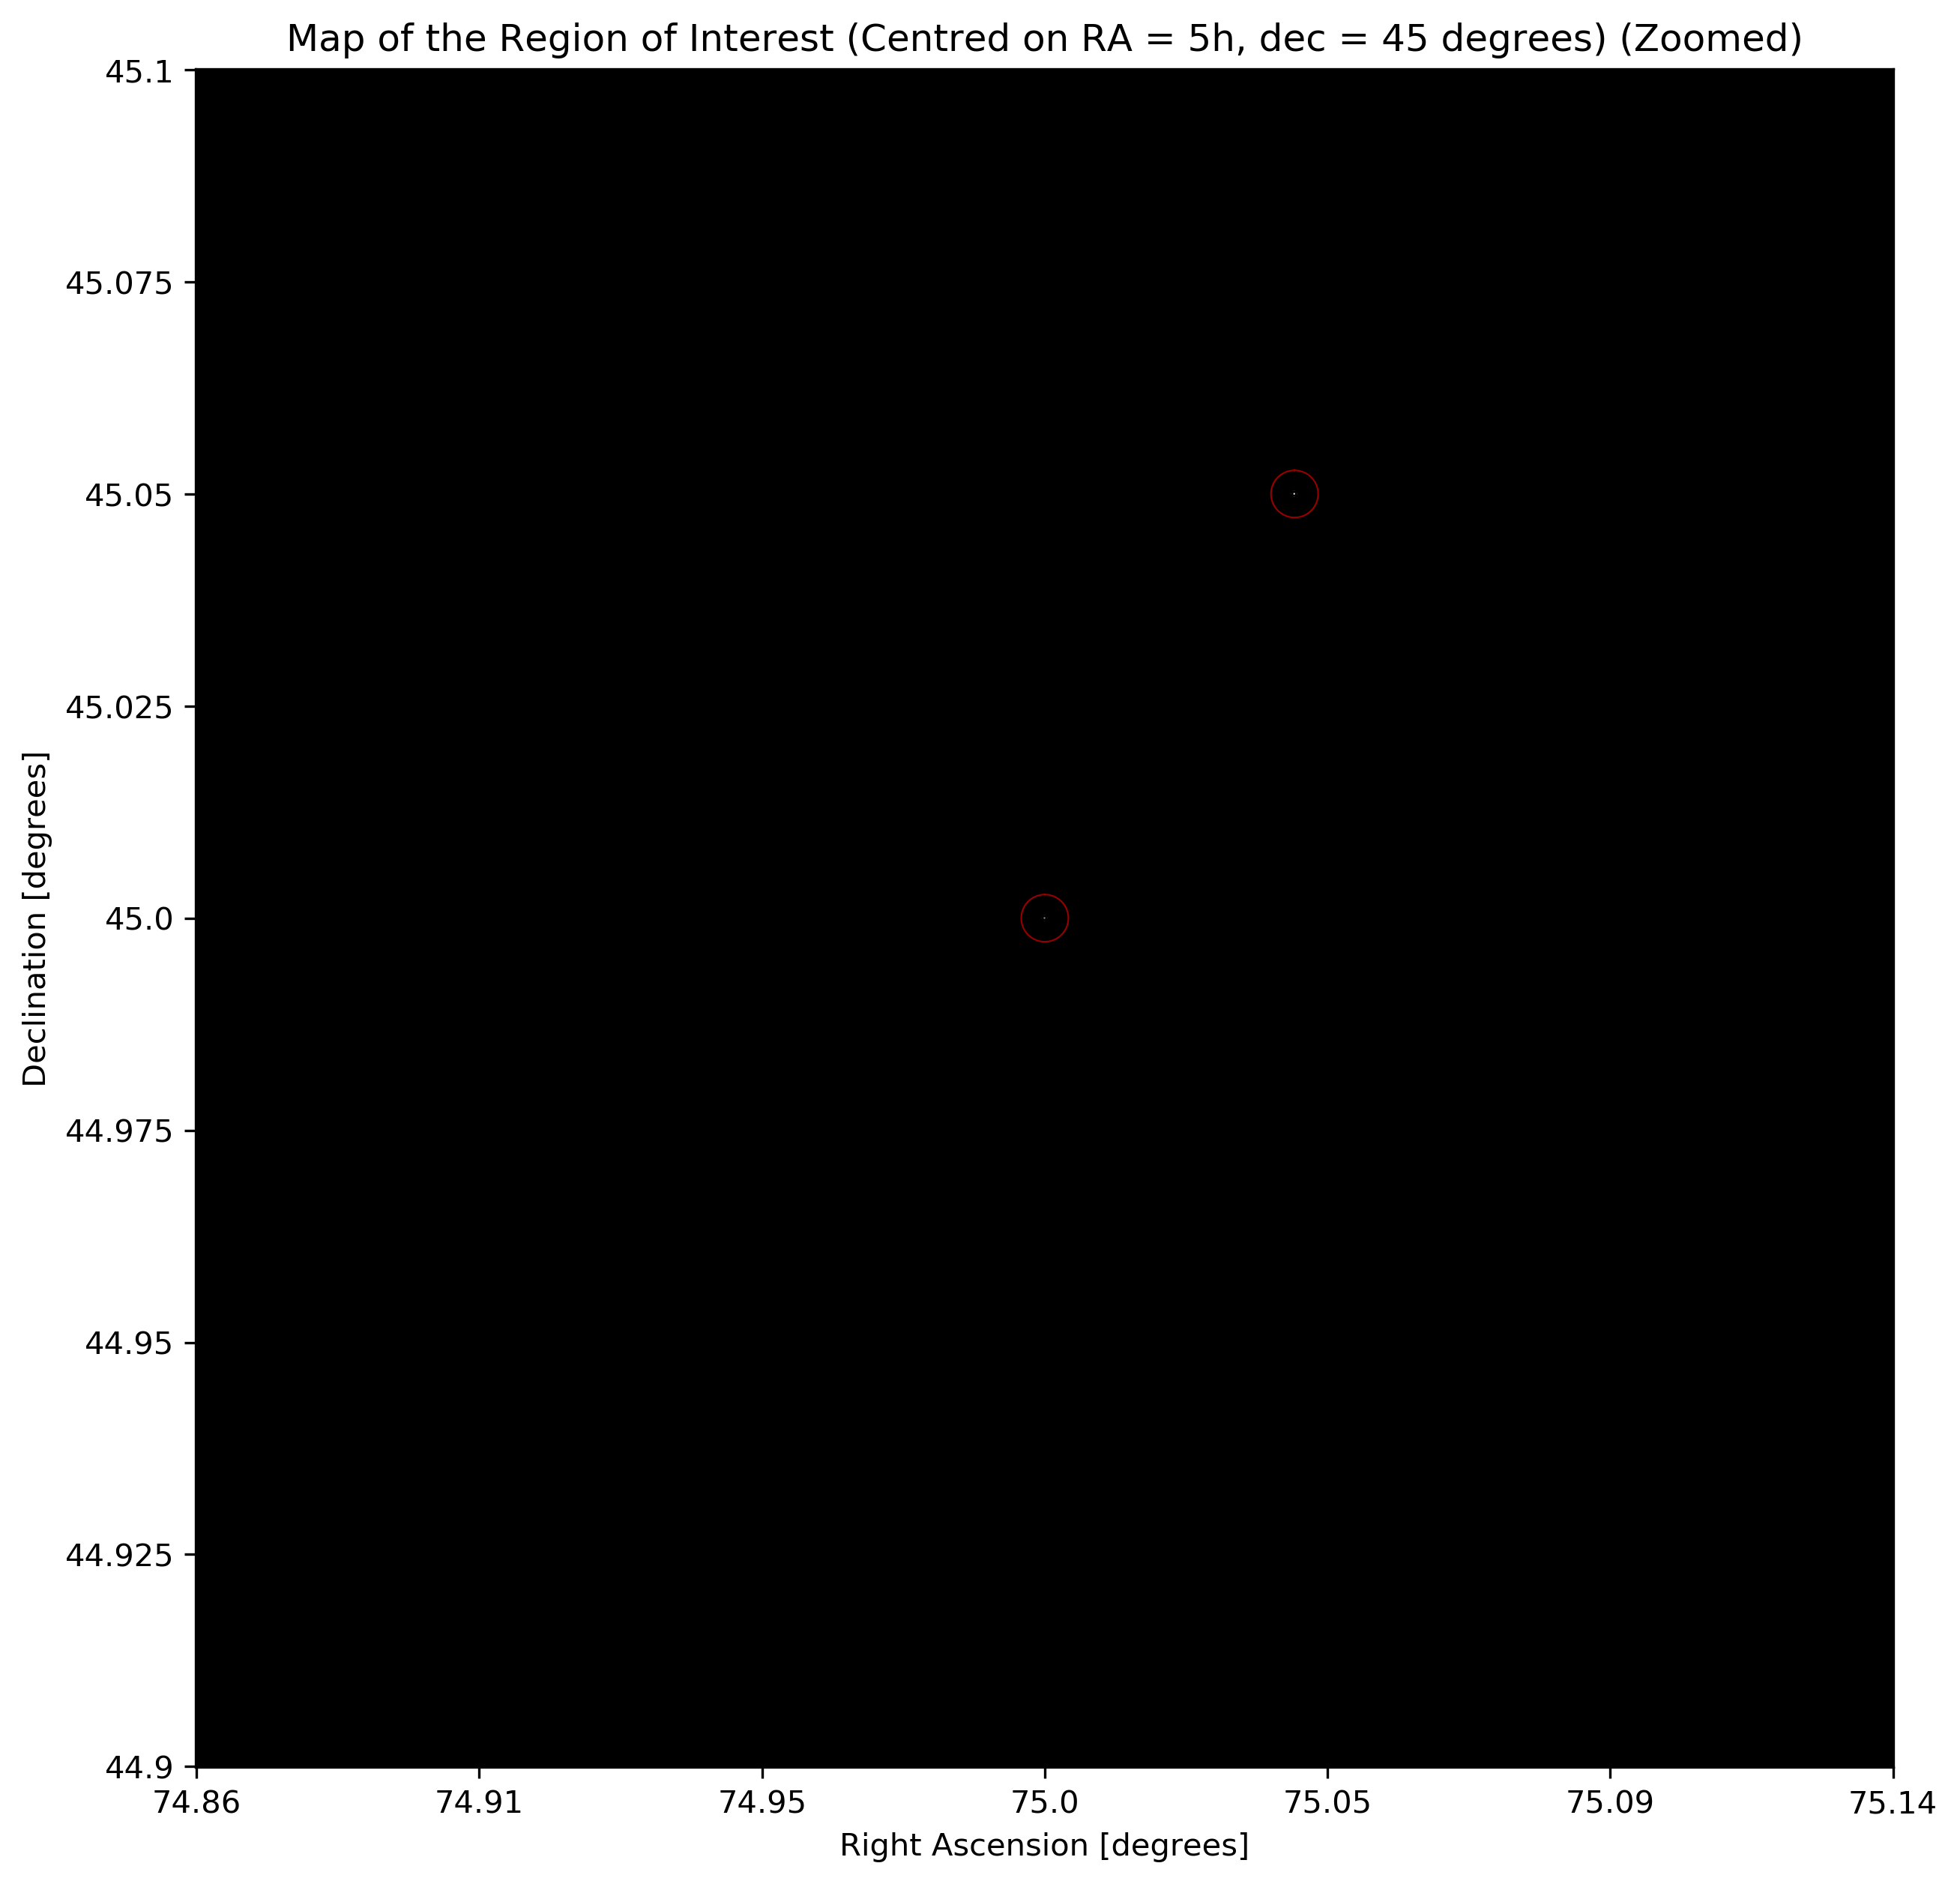

In [12]:
# create circles to highlight point sources

theta = np.arange(0, 2*np.pi, 0.01)
r = 20

xpos = r*np.sin(theta)
ypos = r*np.cos(theta)

# plot field

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(field[lo:hi,lo:hi],interpolation='sinc',cmap='gray',origin='lower')
plt.xticks(ticks_RA,ticklabels_RA)
plt.yticks(ticks_dec,ticklabels_dec)
plt.title('Map of the Region of Interest (Centred on RA = 5h, dec = 45 degrees) (Zoomed)')
plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')

plt.plot(xpos+ra1-lo,ypos+dec1-lo,'r-',linewidth=0.5,alpha=0.6)
plt.plot(xpos+ra2-lo,ypos+dec2-lo,'r-',linewidth=0.5,alpha=0.6)

plt.show()

###### Fig. 3: The relevant region of the sky, featuring the two point sources, which have been circled in red for clarity.


***


# 4. Defining the Primary Beam

Next, the effect of the primary beam is accounted for. Radio telescopes typically have a non-uniform beam profile, and in fact this profile can usually be approximated by a 2D Gaussian (https://www.cv.nrao.edu/~sransom/web/Ch3.html).

The VLA's primary beam size is defined by the Full Width at Half Maximum (FWHM), an approximation for which is given at https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/fov (accessed November 2019):

    FWHM [arcminutes] = 50 / frequency [GHz]

The observation frequency here, 5 GHz, gives a FWHM of 10 arcminutes, or 360 arcseconds.

This is then converted to the 'width' of the Gaussian (using formula from http://mathworld.wolfram.com/GaussianFunction.html):

    width = fwhm/2.35482

In [13]:
# Create Gaussian profile for primary beam to attenuate off-centre sources,
# mirroring real telescope function

k_ = int(round(dims/2))

# Use a meshgrid approach to optimise creation of the 2D Gaussian

x = y = np.arange(-k_,k_)
xx,yy = np.meshgrid(x,y)
z=np.hypot(xx,yy)

# Configure the primary beam profile value using the approximation (fwhm in arcminutes) = 50 / (frequency in GHz))

fwhm_arcmin = 50./(freq/1E9)
fwhm_arcsec = 60.*fwhm_arcmin

# Convert to units of pixels using the pixel size in arcseconds

fwhm = fwhm_arcsec/pixelsize_arcsec

# Finally calculate 'width' of Gaussian function from FWHM

w = fwhm/2.35482

In [14]:
# Create primary beam image array (normalised to a maximum of 1)

# NB this line of code will kill the kernel if run using a jupyter notebook inside binder
# this happens at various subsequent points in the notebook

# The entire notebook runs fine in a regular jupyter notebook

primary_beam = np.exp(-z*z/(2*w*w))

Before each plot, the zoomed array boundaries and coordinate labels can be generated, allowing the zoom level to be customised for each plot as required. The zoom level here is kept the same as in Fig. 3 to allow for easy comparison:

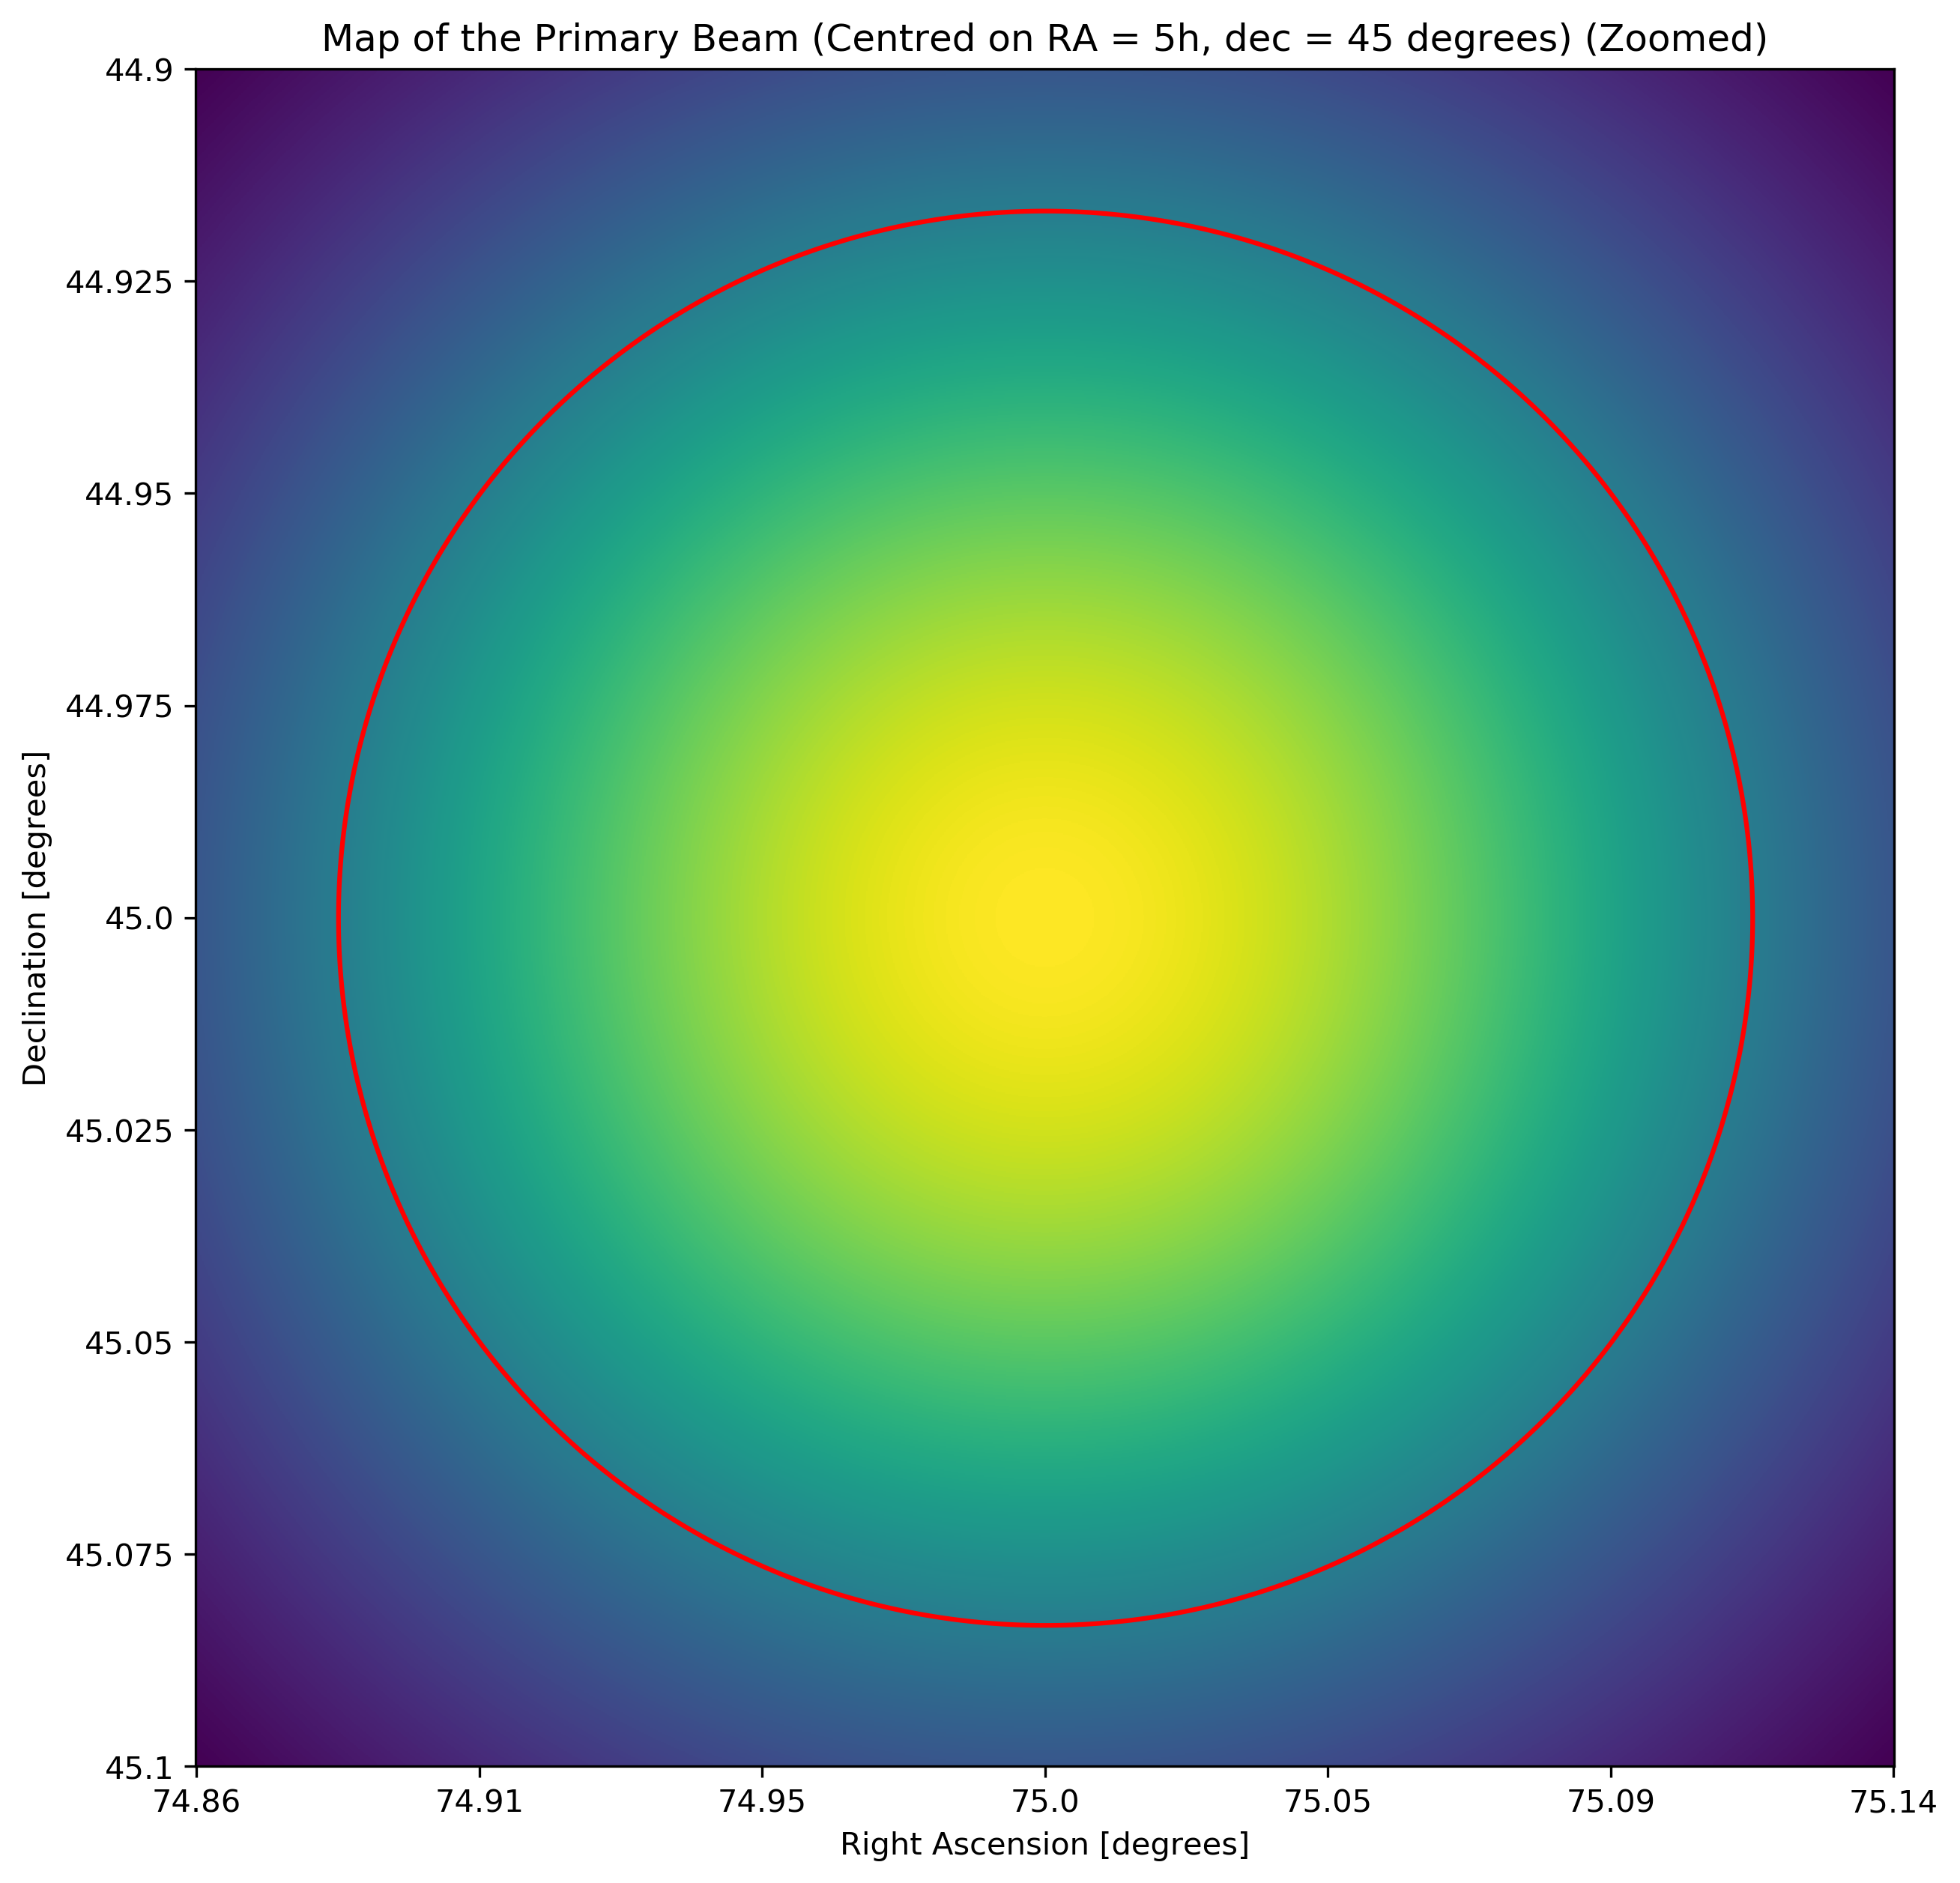

In [15]:
# for greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/5

# create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

# use the size of the zoomed-in area to create meaningful plot labels in astronomical coordinates

tickrange = window
tickspace_RA = (window)/6
tickspace_dec = (window)/8
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA  = []
ticklabels_dec = []
for i in range(len(ticks_RA)):
    ticklabels_RA.append(round(RA[lo+int(np.round(ticks_RA[i]))],2))
for i in range(len(ticks_dec)):
    ticklabels_dec.append(round(dec[lo+int(np.round(ticks_dec[i]))],3))

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(primary_beam[lo:hi,lo:hi])
plt.contour(primary_beam[lo:hi,lo:hi],(0,0.5*primary_beam.max()),colors='r',origin='lower')
plt.xticks(ticks_RA,ticklabels_RA)
plt.yticks(ticks_dec,ticklabels_dec)
plt.title('Map of the Primary Beam (Centred on RA = 5h, dec = 45 degrees) (Zoomed)')
plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')
plt.show()

###### Fig. 4: A map of the primary beam profile and its half-power level at the same scale as the field in Fig. 3.

For the true input field, i.e. what the VLA telescopes 'see', we adjust each pixel in the sky array by multiplying it by the beam response function in that pixel, dependent on the displacement from the centre of the field.

Given that we created the 'sky' array and the primary beam array with the same dimensions, this is a simple element-by-element array multiplication:

In [16]:
# Modify field array given primary beam response function

field = field * primary_beam

Display the response of the VLA telescopes to the field from Fig. 3 (again using interpolation to make the point sources more visible), and apply astronomical coordinate labels for context. This time, overlay the field with the half-power threshold of the primary beam:

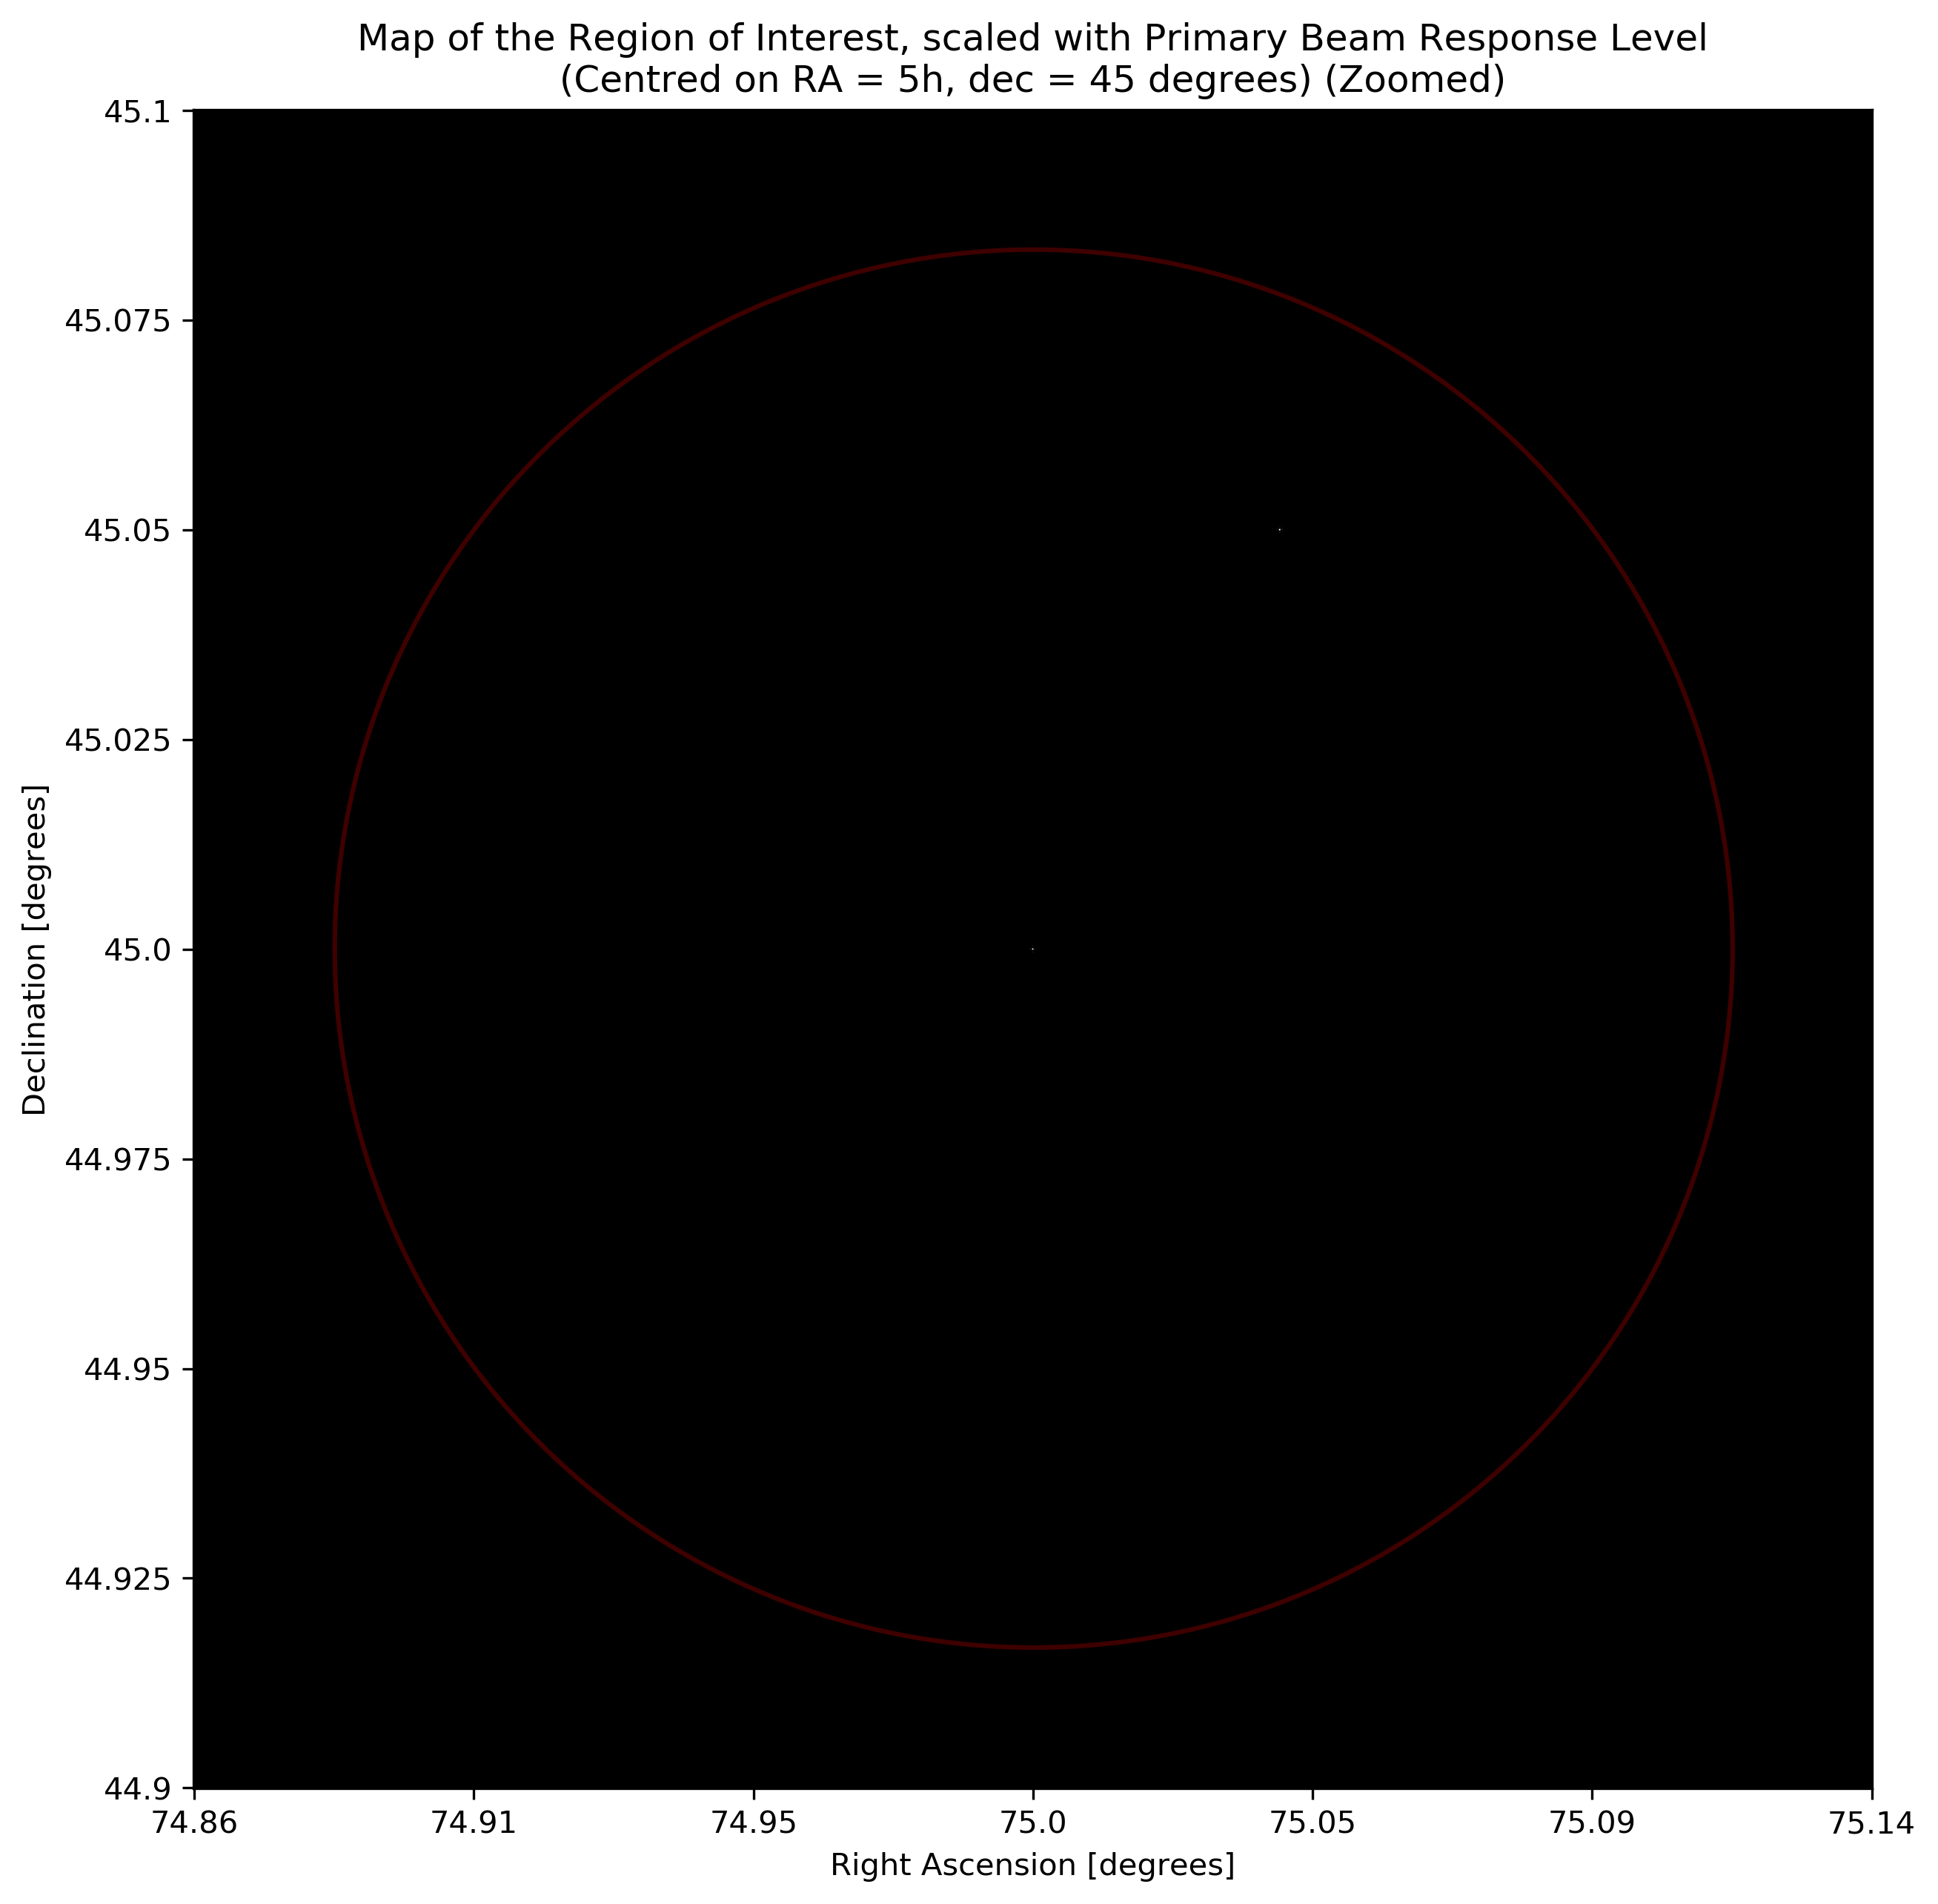

In [17]:
# For greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/5

# Create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

# Use the size of the zoomed-in area to create meaningful plot labels in astronomical coordinates

tickrange = window
tickspace_RA = (window)/6
tickspace_dec = (window)/8
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA  = []
ticklabels_dec = []
for i in range(len(ticks_RA)):
    ticklabels_RA.append(round(RA[lo+int(np.round(ticks_RA[i]))],2))
for i in range(len(ticks_dec)):
    ticklabels_dec.append(round(dec[lo+int(np.round(ticks_dec[i]))],3))

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(field[lo:hi,lo:hi],interpolation='sinc',cmap='gray',origin='lower')
plt.contour(primary_beam[lo:hi,lo:hi],(0,0.5*primary_beam.max()),colors='r',origin='lower',alpha=0.25)
plt.xticks(ticks_RA,ticklabels_RA)
plt.yticks(ticks_dec,ticklabels_dec)
plt.title('Map of the Region of Interest, scaled with Primary Beam Response Level\n(Centred on RA = 5h, dec = 45 degrees) (Zoomed)')
plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')
plt.show()

###### Fig. 5: The input field, attenuated by the primary beam profile and overlaid with the half-power contour of the beam.


***


# 5. Producing a UV-plane Interference Pattern

We can use the 'fast fourier transform' function provided by numpy to produce the uv-plane interference signal (or "response function") which results from the given field - this is what is probed by the interferometer.

This UV plane has a pixel size which is related to the pixel size of the sky array above.

In [18]:
def ft(image):
    return np.fft.fftshift(np.fft.fft2(image))

ftsky = ft(field)

The UV-plane response function is complex-valued, so to display it we can choose to show the magnitude of the complex value in each pixel:

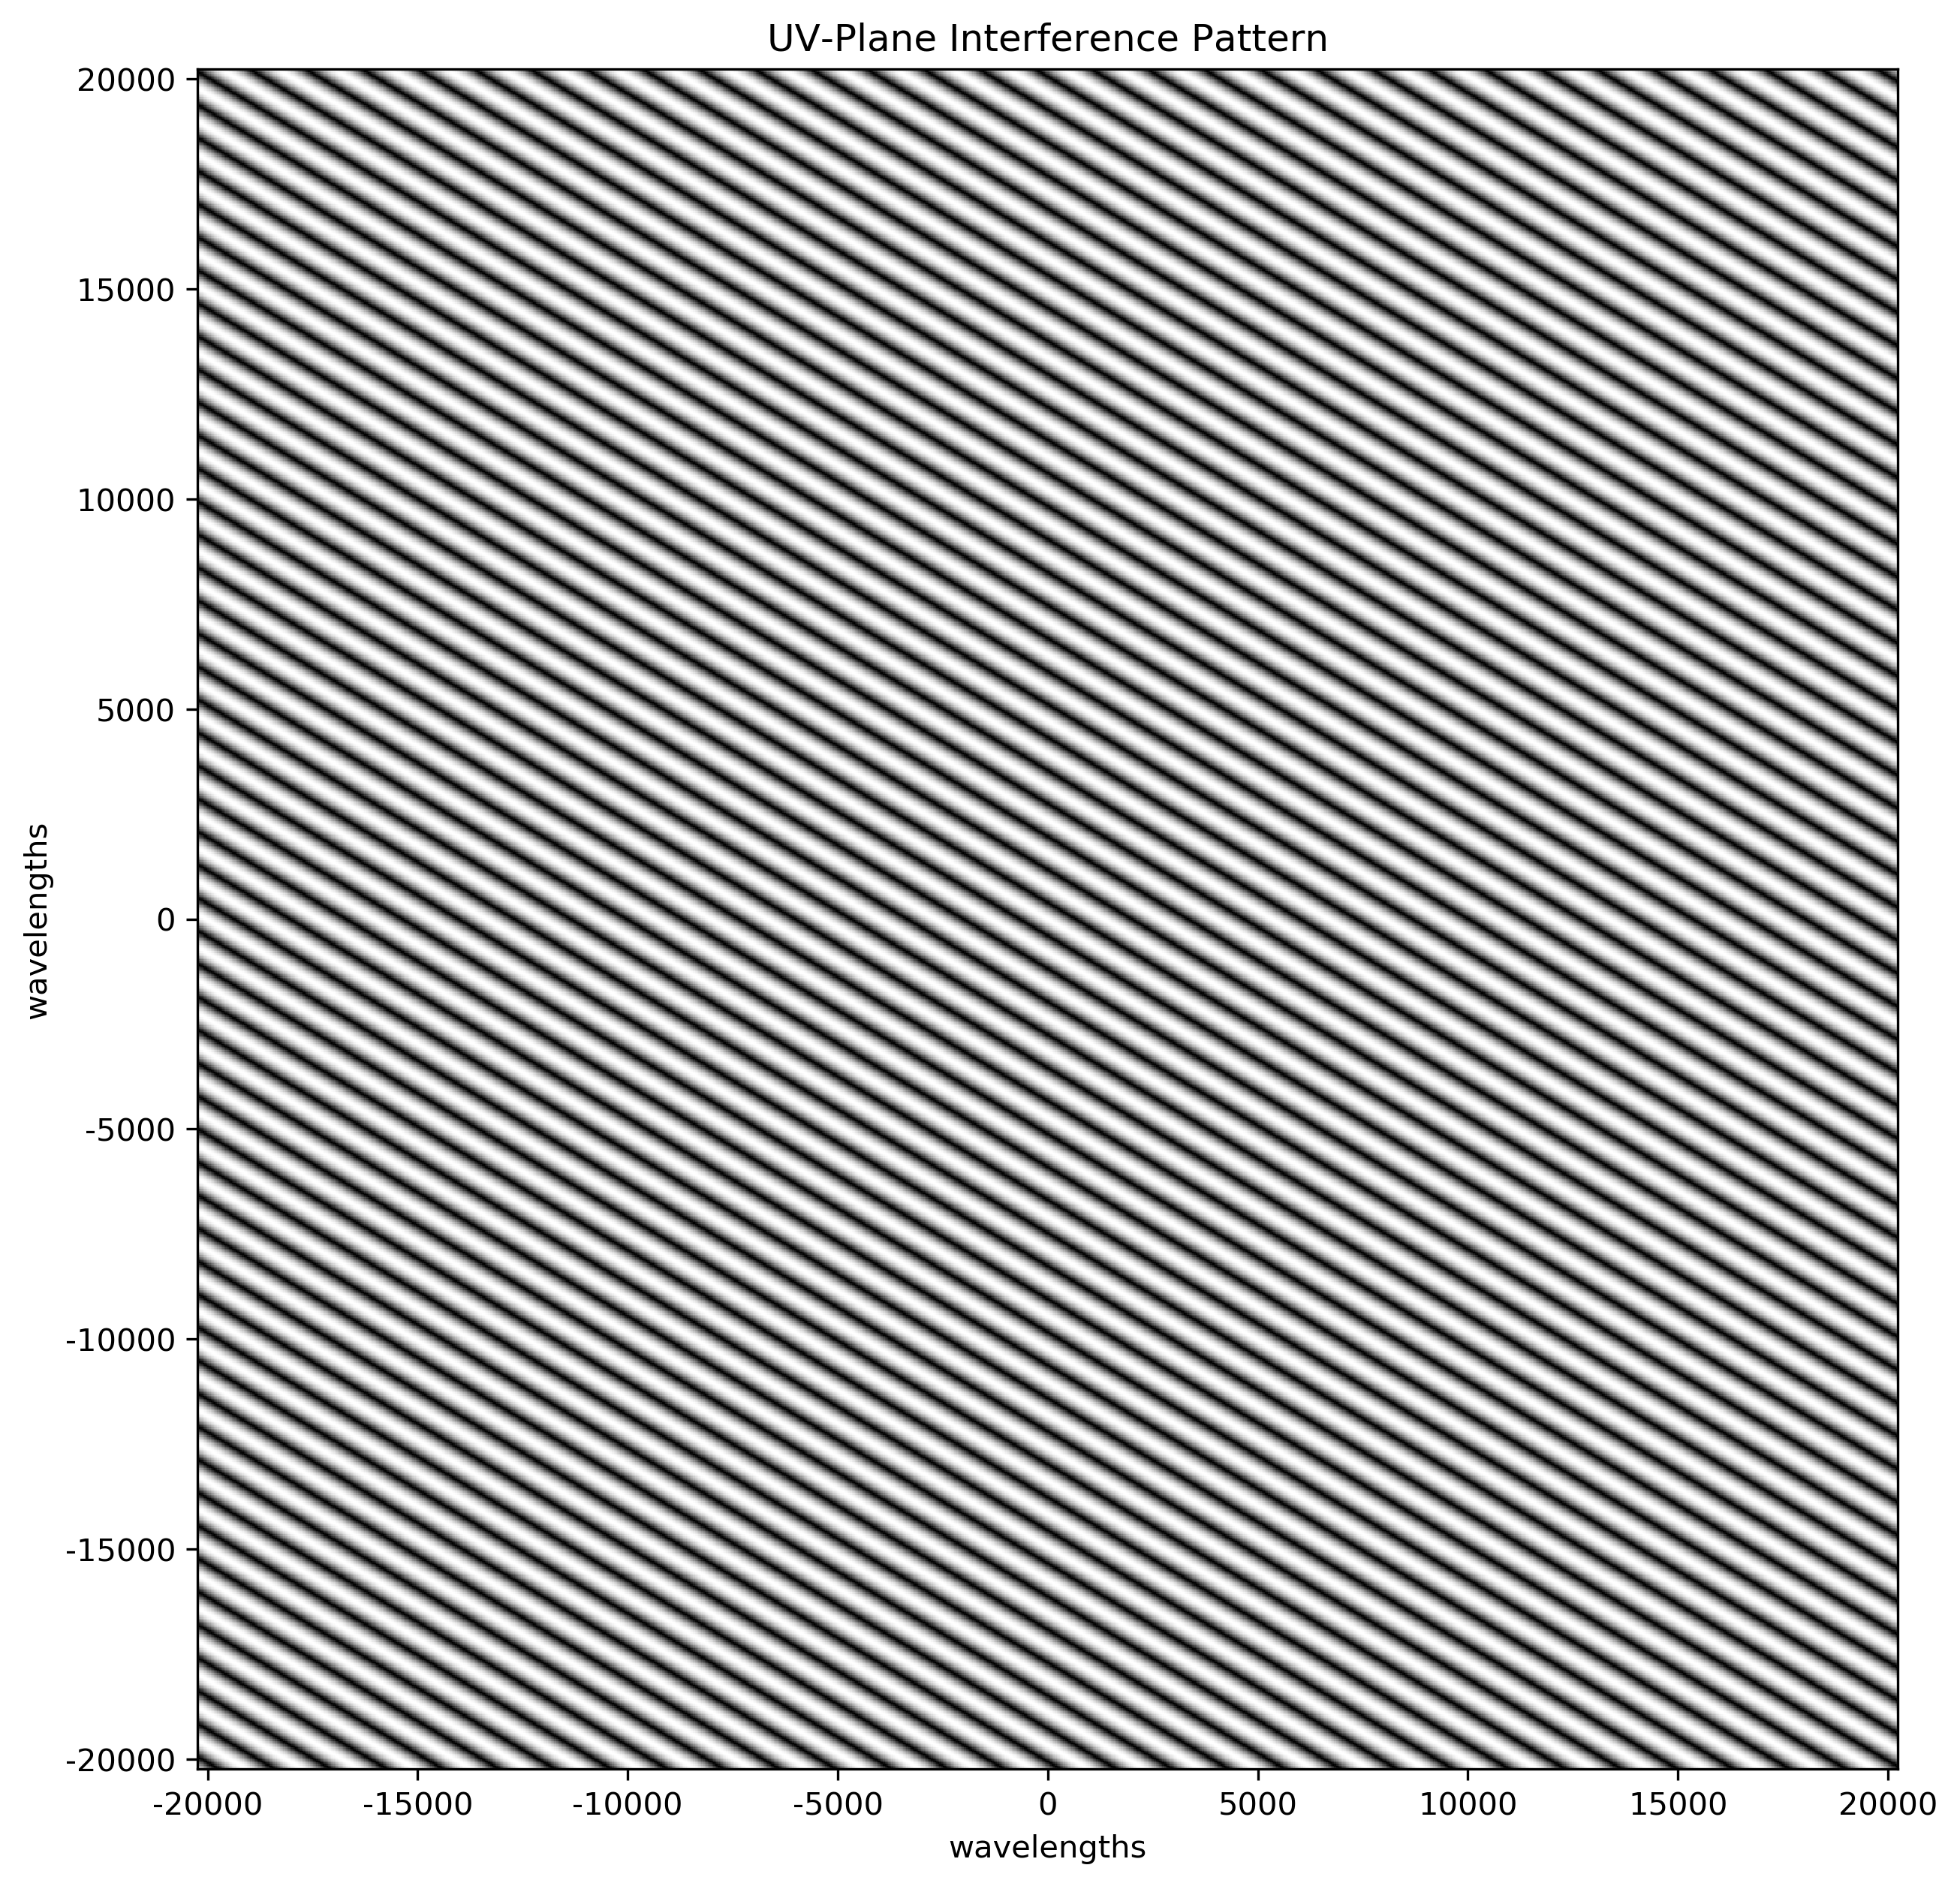

In [19]:
# for greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/7

# create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

mid = int(round((hi-lo)/2))

wvln_step = 5000
ticks_uv = np.arange(0,mid+1,wvln_step/39.33)
ticks_uv = list(dict.fromkeys(np.concatenate((-np.flip(ticks_uv),ticks_uv))))


ticklabels_uv = []
for i in range(len(ticks_uv)):
    ticklabels_uv.append(np.int(ticks_uv[i]*39.33))

for i in range(len(ticks_uv)):
    ticks_uv[i] += mid

# plot the uv-plane produced by the two point sources (using the magnitude of the complex values)

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(np.abs(ftsky)[lo:hi,lo:hi],interpolation='none',cmap='gray',origin='lower')
plt.title('UV-Plane Interference Pattern')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.xticks(ticks_uv,ticklabels_uv)
plt.yticks(ticks_uv,ticklabels_uv)
plt.show()

###### Fig. 6: A zoomed-in view of the interference pattern created by the pair of point sources.

To find pixel sizes in the UV plane in units of wavelengths, the separation of the two point sources can be varied, and the pixel separation in uv-space of the periodic variations (i.e. those pictured above) measured, which can then be compared with the 'real' value in units of wavelengths (206265/a).

By performing this variation for various point source separations and for various pixel sizes, it is possible to find a linear relationship between the separation in units of pixels and wavelengths, thus leading to an expression for the uv pixel sizes in units of wavelengths.

The peak separations are related linearly, in the following way:

    uv peak separation [wavelengths] = k * uv peak separation [pixels]

    where:  k = sky pixel size [arcseconds per pixel] * constant [wavelengths per arcsecond]

Thus the units of k are 'wavelengths per pixel', constituting a pixel size in the UV plane:

    uv pixel size [wavelengths per pixel] = sky pixel size [arcseconds per pixel] * constant [wavelengths per arcsecond]

The value for the constant was found to be 78.67. In fact, as we are dealing with peak separation in the absolute value space, the real period of the oscillations is twice that found here, and the conversion constant is halved, thus is 39.33.


***


# 6. Scaling the VLA's UV Coverage to Match the Fourier Transformed UV Array

To probe the UV-plane response function produced by the input field, the UV coverage in Fig. 2 must be scaled using the relation from above.

Baselines and observations are iterated over as in section 2, but this time the UV displacements are scaled to match the UV plane above, and binned according to the UV pixel being probed at that location.

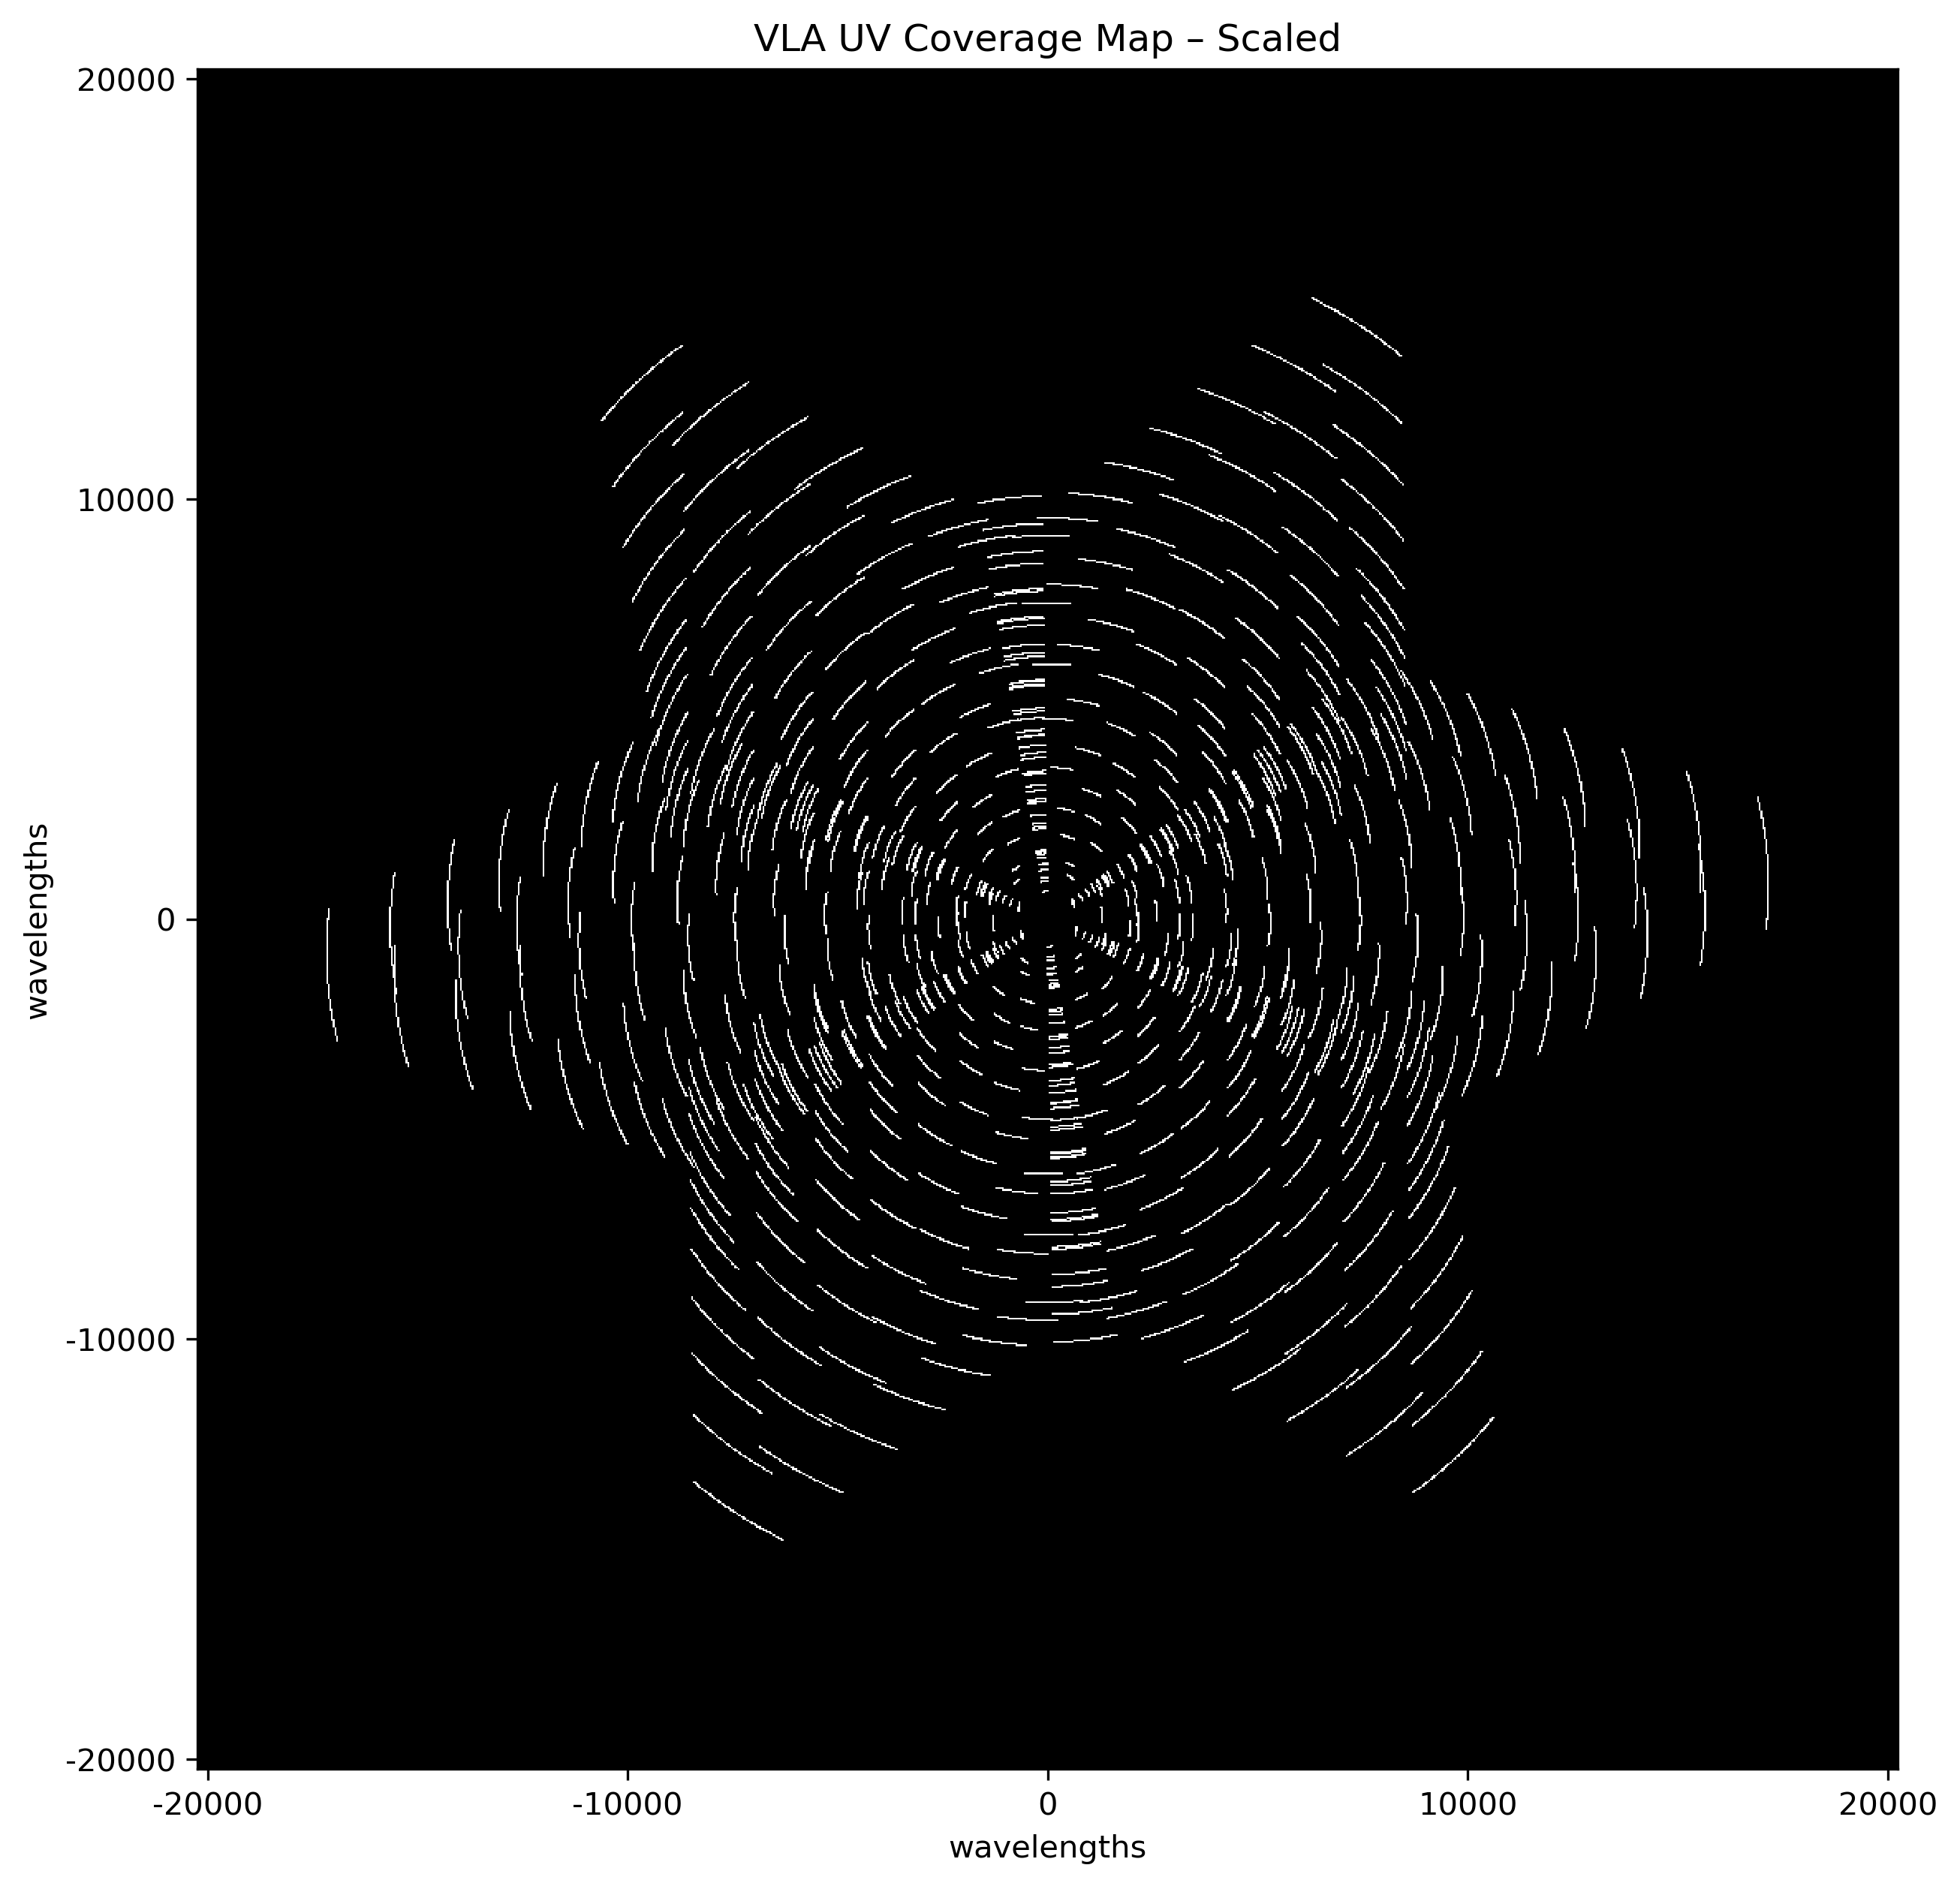

In [20]:
# Create a uv-space array with the same dimensions as the fourier transformed sky (above)

uv_tracks = np.zeros((dims,dims))

# Observations are carried out every 30 seconds over the period ± 0.5 hours of culmination
# i.e. 121 observations in total

# Entire circle is 24h and 2pi radians, so multiply by pi/12 to convert from hours to radians

obs = (np.pi/12.) * np.linspace(-0.5,0.5,121) # units of hours

mid = int(round(dims/2))

# create uv tracks as before, but this time adding each uv measurement to the scaled array

for i in range(len(pairs)):
    # Each baseline contributes two uv vectors (one in each direction)
    Lx,  Ly,  Lz  = pairs[i][3] - pairs[i][2]
    Lx_, Ly_, Lz_ = pairs[i][2] - pairs[i][3]
    
    for H0 in obs:
        
        # Calculate ∆u and ∆v in units of wavelengths
        # Uses equation 4.1 from 'Interferometry and Synthesis in Radio Astronomy, Third Edition'
        # (Thompson, Moran & Swenson 2017)
        
        u_wvln  = (1/wvln)*(np.sin(H0)*Lx + np.cos(H0)*Ly)
        v_wvln  = (1/wvln)*(-np.sin(d0)*np.cos(H0)*Lx + np.sin(d0)*np.sin(H0)*Ly + np.cos(d0)*Lz)
        
        u_wvln_ = (1/wvln)*(np.sin(H0)*Lx_ + np.cos(H0)*Ly_)
        v_wvln_ = (1/wvln)*(-np.sin(d0)*np.cos(H0)*Lx_ + np.sin(d0)*np.sin(H0)*Ly_ + np.cos(d0)*Lz_)
        
        # Scale ∆u and ∆v to pixel sizes in the scaled array
        # Scale factor is 1/k or 1/(39.33*[pixel size in arcseconds]), from above
        # (where 'pixel size' refers to the sky plane)
        
        u  = mid + int(round((u_wvln/39.33)))
        v  = mid + int(round((v_wvln/39.33)))
        
        u_ = mid + int(round((u_wvln_/39.33)))
        v_ = mid + int(round((v_wvln_/39.33)))
        
        # Change any pixel where a uv measurement appears to 1
        
        uv_tracks[v][u] = 1
        uv_tracks[v_][u_] = 1

# for greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/7

# create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

mid = int(round((hi-lo)/2))

wvln_step = 10000
ticks_uv = np.arange(0,mid+1,wvln_step/39.33)
ticks_uv = list(dict.fromkeys(np.concatenate((-np.flip(ticks_uv),ticks_uv))))

ticklabels_uv = []
for i in range(len(ticks_uv)):
    ticklabels_uv.append(np.int(ticks_uv[i]*39.33))

for i in range(len(ticks_uv)):
    ticks_uv[i] += mid

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(uv_tracks[lo:hi,lo:hi],cmap='gray',origin='lower')
plt.title('VLA UV Coverage Map – Scaled')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.xticks(ticks_uv,ticklabels_uv)
plt.yticks(ticks_uv,ticklabels_uv)
plt.show()

###### Fig. 7: The binned UV coverage of this observation. Some pixellation is visible due to the discretization of the UV space inherent to computational methods. The scale of this image is the same as the diagram of the complete response function in Fig. 6.


***


# 7. How the Interferometer Probes the UV Response Function

To illustrate how the interferometer behaves during an observation, we can isolate a baseline from the full set of 351, and plot the interference signal between the baseline's telescope pair.

We iterate over the 121 observations, however this time over just one baseline. For this baseline, the UV coverage is shown and the measured response function is plotted.

We can choose a baseline by specifying two antenna numbers. Antenna IDs count up from the closest antenna to the array centre, in the order: south-west, south-east, north.

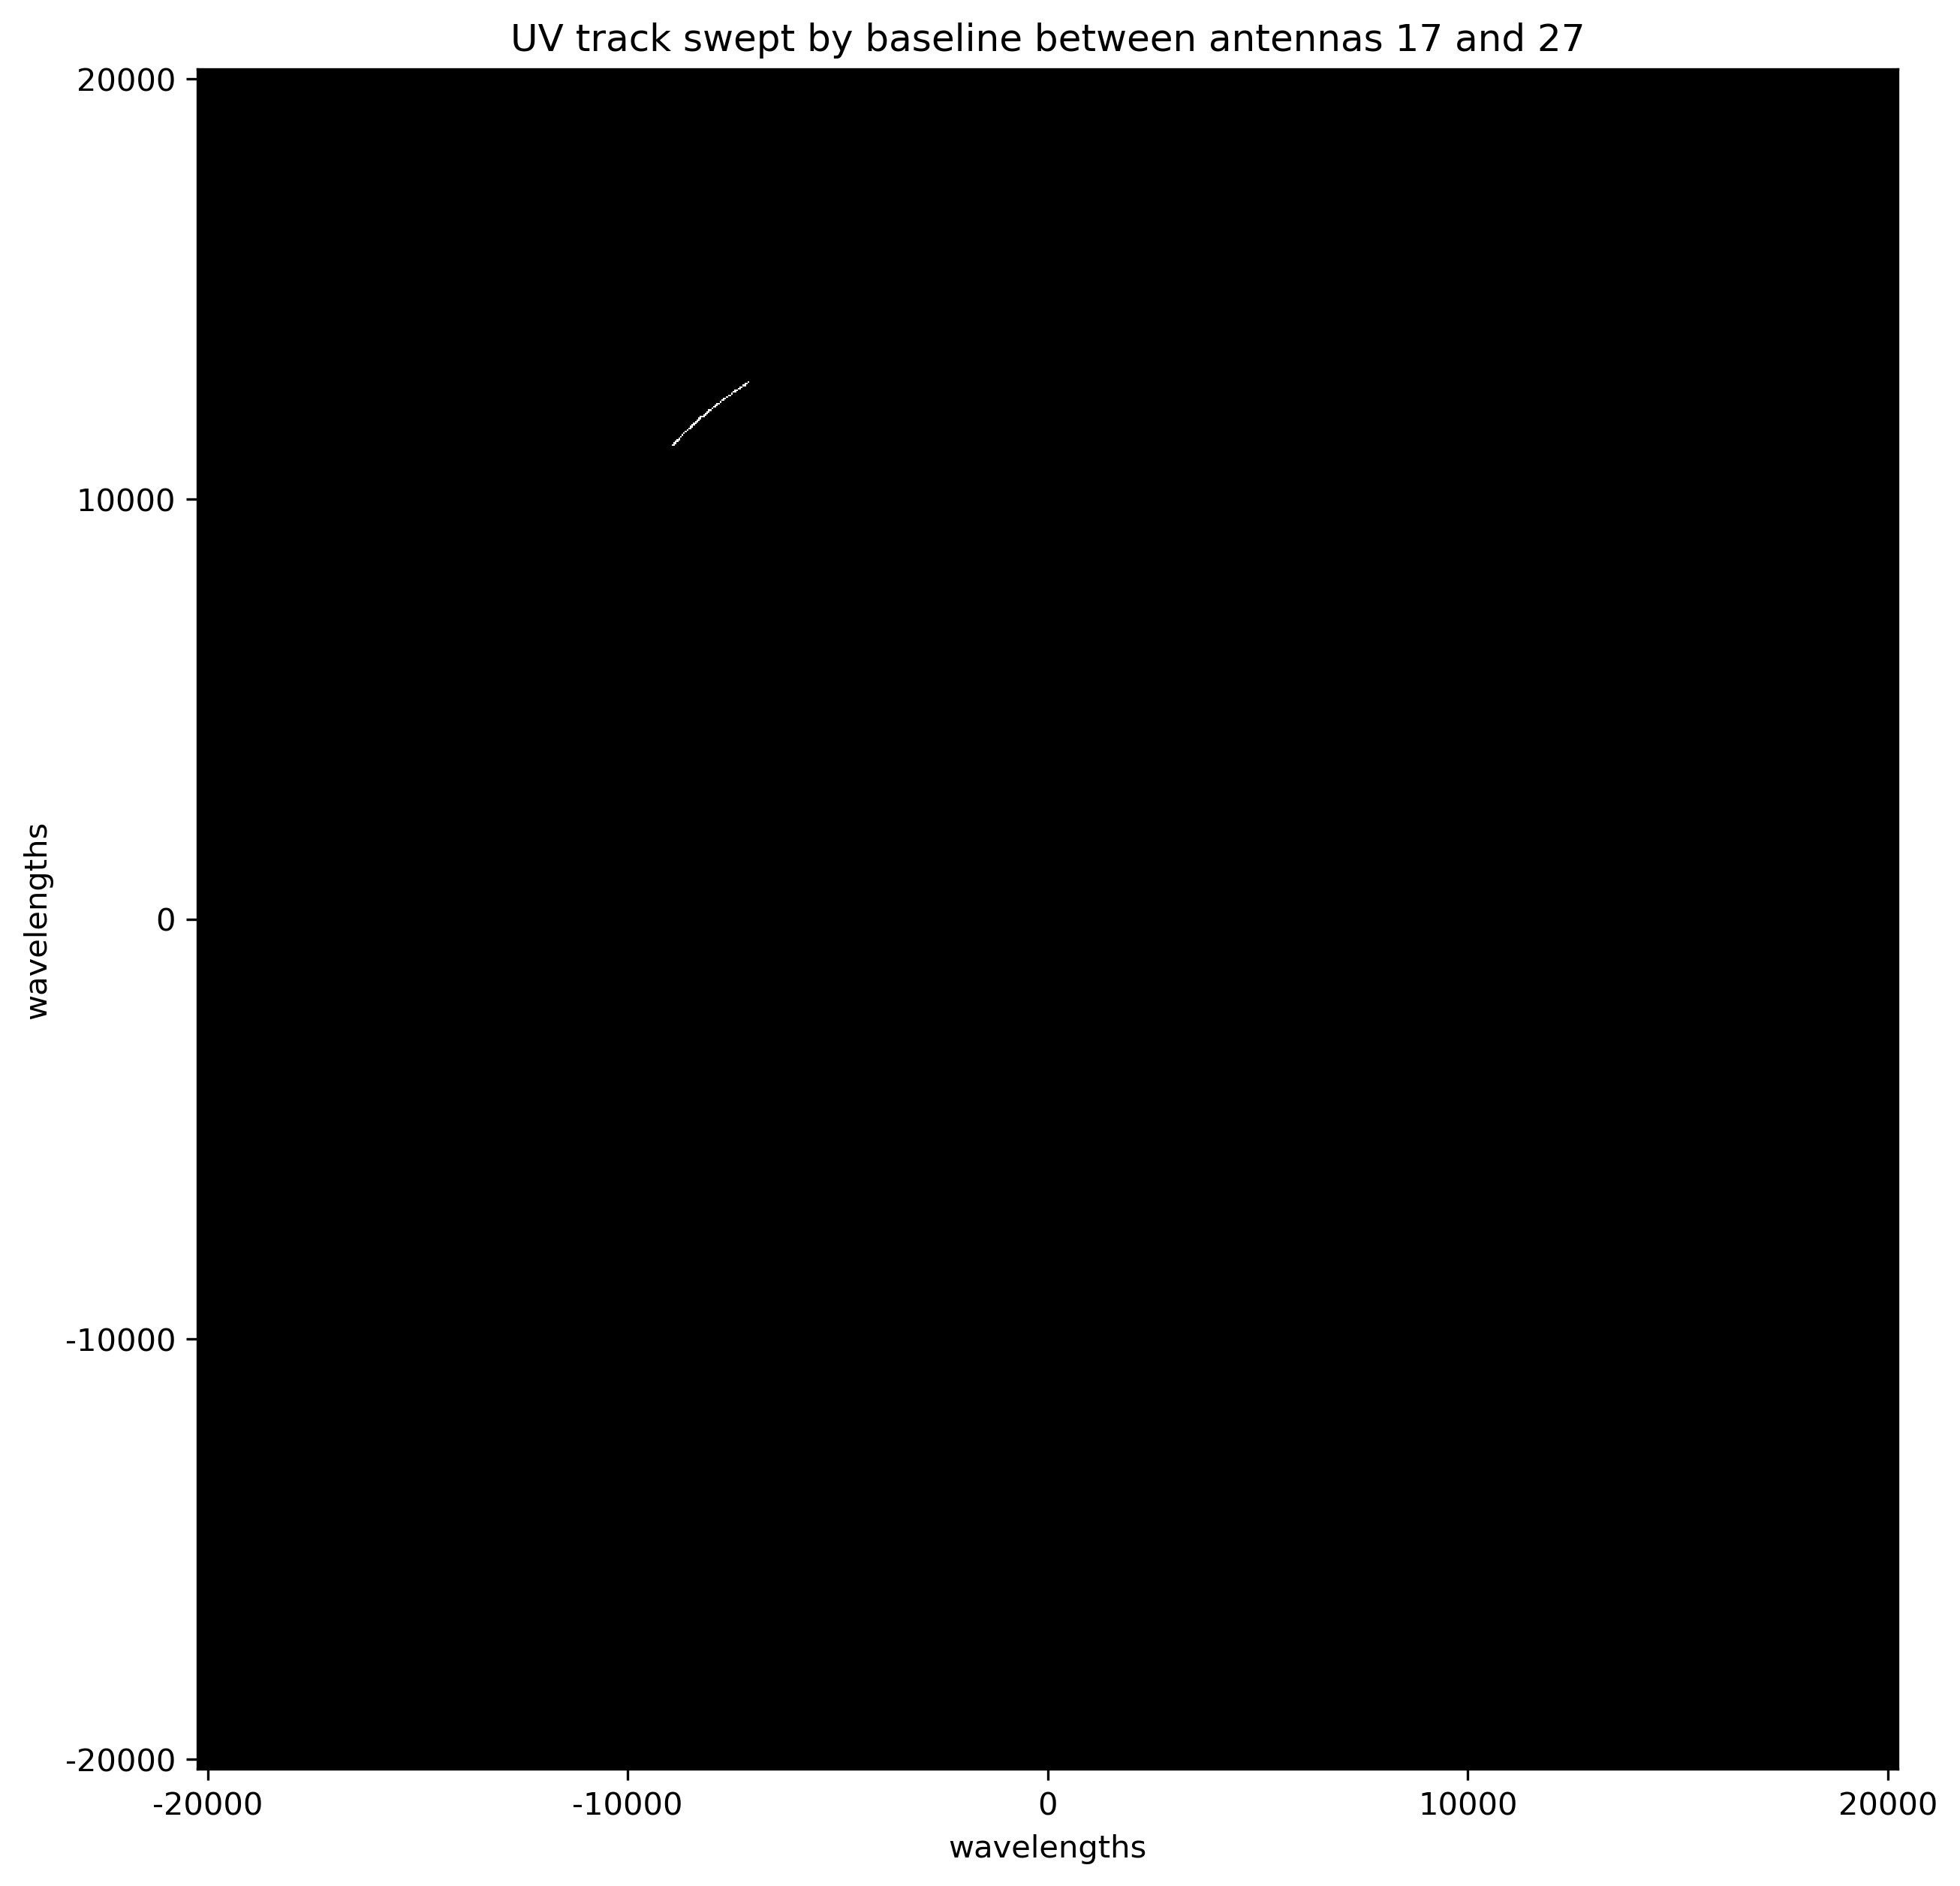

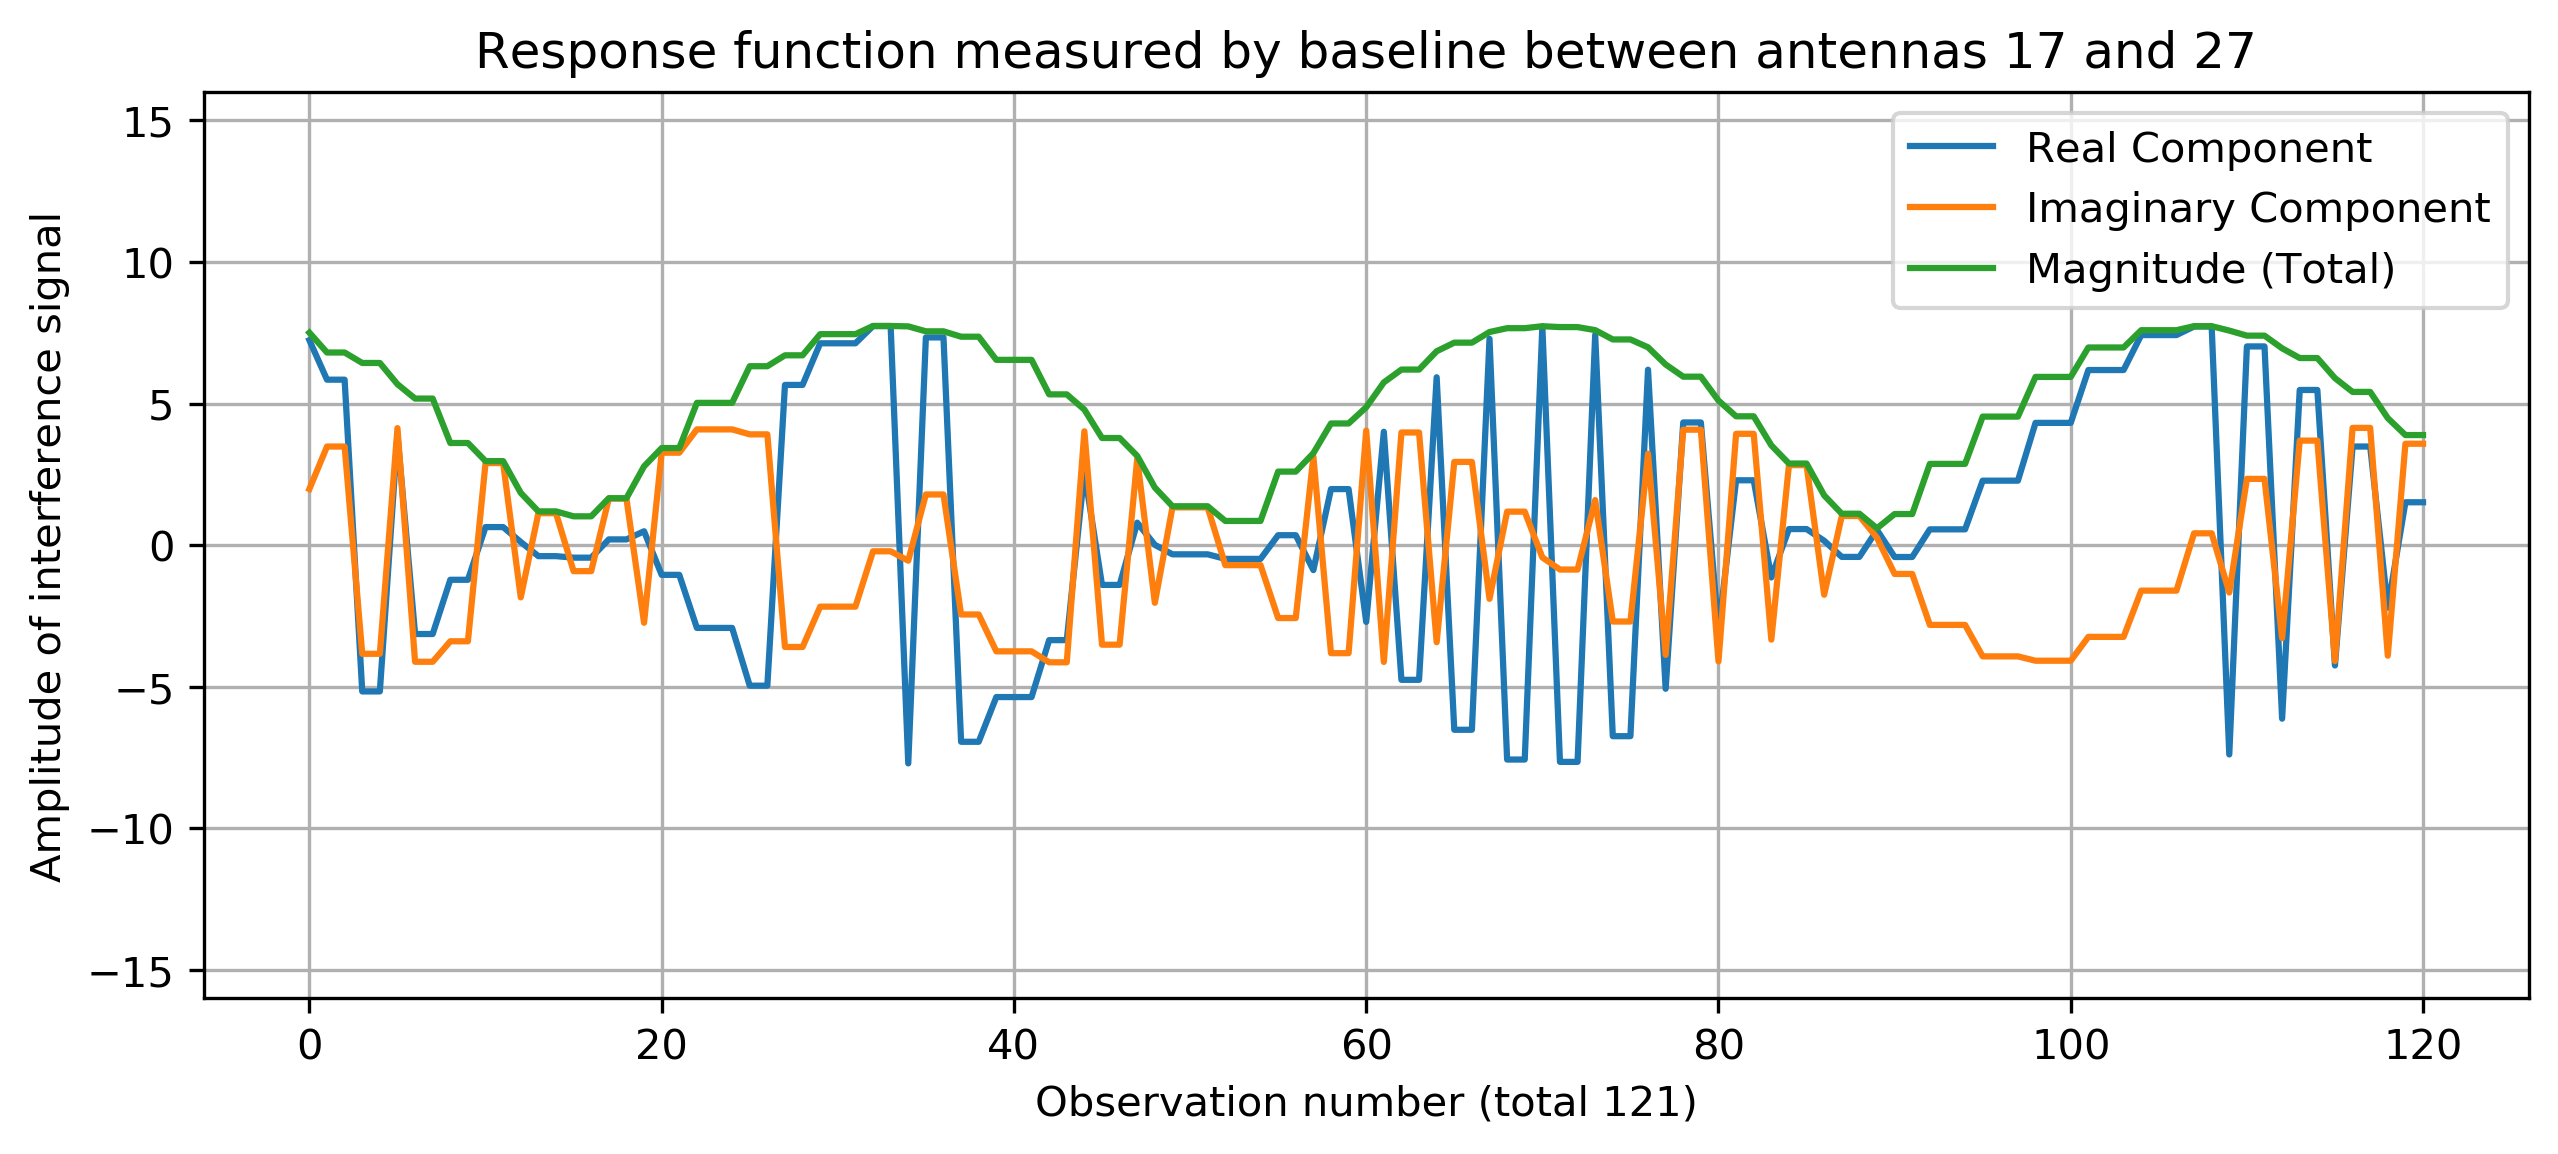

In [21]:
# enter desired antenna IDs in brackets (counts from 1 whereas python counts from zero)

ant1 = (17) - 1
ant2 = (27) - 1

if ant1>26 or ant2>26:
    print('INVALID')
if ant1 > ant2:
    temp = ant2
    ant2 = ant1
    ant1 = temp

# retrieve coordinates for these antennas and calculate UV displacement

a = pairs[np.where(pairs[:,0] == ant1)]
b = a[np.where(a[:,1] == ant2)][0]

# retrieve baseline displacements for given antenna pair

Lx,  Ly,  Lz  = b[3] - b[2]

obs = (np.pi/12.) * np.linspace(-0.5,0.5,121) # units of hours

# initialise arrays for storing the real, imaginary and absolute-valued signals

signal_real = []
signal_imag = []
signal_abs  = []


i=0

# initialise array for storing the UV plane for this baseline

uv_tracks2 = np.zeros((dims,dims))

for H0 in obs:
    
    # Calculate ∆u and ∆v in units of wavelengths
    # Uses equation 4.1 from 'Interferometry and Synthesis in Radio Astronomy, Third Edition'
    # (Thompson, Moran & Swenson 2017)
    
    u_wvln  = (1/wvln)*(np.sin(H0)*Lx + np.cos(H0)*Ly)
    v_wvln  = (1/wvln)*(-np.sin(d0)*np.cos(H0)*Lx + np.sin(d0)*np.sin(H0)*Ly + np.cos(d0)*Lz)
    
    # Scale ∆u and ∆v to pixel sizes in the scaled array
    # Scale factor is 1/k or 1/(39.33*[pixel size in arcseconds]), from above
    # (where 'pixel size' refers to the sky plane)
    
    u  = int(round(dims/2)) + int(round((u_wvln/39.33)))
    v  = int(round(dims/2)) + int(round((v_wvln/39.33)))
    
    # Measure the response function in the current pixel and add to array
    
    signal_real.append(np.real(ftsky[v][u]))
    signal_imag.append(np.imag(ftsky[v][u]))
    signal_abs.append(np.abs(ftsky[v][u]))
    
    # Change the uv coverage pixel value to 1
    
    uv_tracks2[v][u] = 1

# for greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/7

# create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

mid = int(round((hi-lo)/2))

wvln_step = 10000
ticks_uv = np.arange(0,mid+1,wvln_step/39.33)
ticks_uv = list(dict.fromkeys(np.concatenate((-np.flip(ticks_uv),ticks_uv))))

ticklabels_uv = []
for i in range(len(ticks_uv)):
    ticklabels_uv.append(np.int(ticks_uv[i]*39.33))

for i in range(len(ticks_uv)):
    ticks_uv[i] += mid

title  = 'UV track swept by baseline between antennas ' + str(ant1+1) + ' and ' + str(ant2+1)

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(uv_tracks2[lo:hi,lo:hi],cmap='gray',origin='lower')
plt.title(title)
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.xticks(ticks_uv,ticklabels_uv)
plt.yticks(ticks_uv,ticklabels_uv)
plt.show()

title2 = 'Response function measured by baseline between antennas ' + str(ant1+1) + ' and ' + str(ant2+1)

plt.figure(figsize=(10,4),dpi=300)
plt.plot(signal_real,label='Real Component')
plt.plot(signal_imag,label='Imaginary Component')
plt.plot(signal_abs,label='Magnitude (Total)')
plt.title(title2)
plt.xlabel('Observation number (total 121)')
plt.ylabel('Amplitude of interference signal')
plt.legend()
plt.grid()
plt.ylim(-16,16)
plt.show()

###### Fig. 8: 
###### Top: Diagram illustrating the specific UV track created by the baseline in question.
###### Bottom: The real, imaginary and total signals measured along this baseline as the UV track is swept out. The source is directly overhead (i.e. hour angle of 0) at observation number 60.


***


# 8. The Synthesized Beam

The synthesized or 'dirty' beam is found by inverse Fourier transforming the UV coverage map created by the interferometer. While the primary beam has a FWHM of 10 arcminutes, the synthesized beam is much smaller allowing for much greater resolution. This is the purpose of imaging using interferometry.

In [22]:
def ift(image):
    return np.fft.ifft2(image)

# Synthesized beam is the *inverse* fourier transform of the uv coverage map

dirty_beam = np.fft.fftshift(ift(uv_tracks))

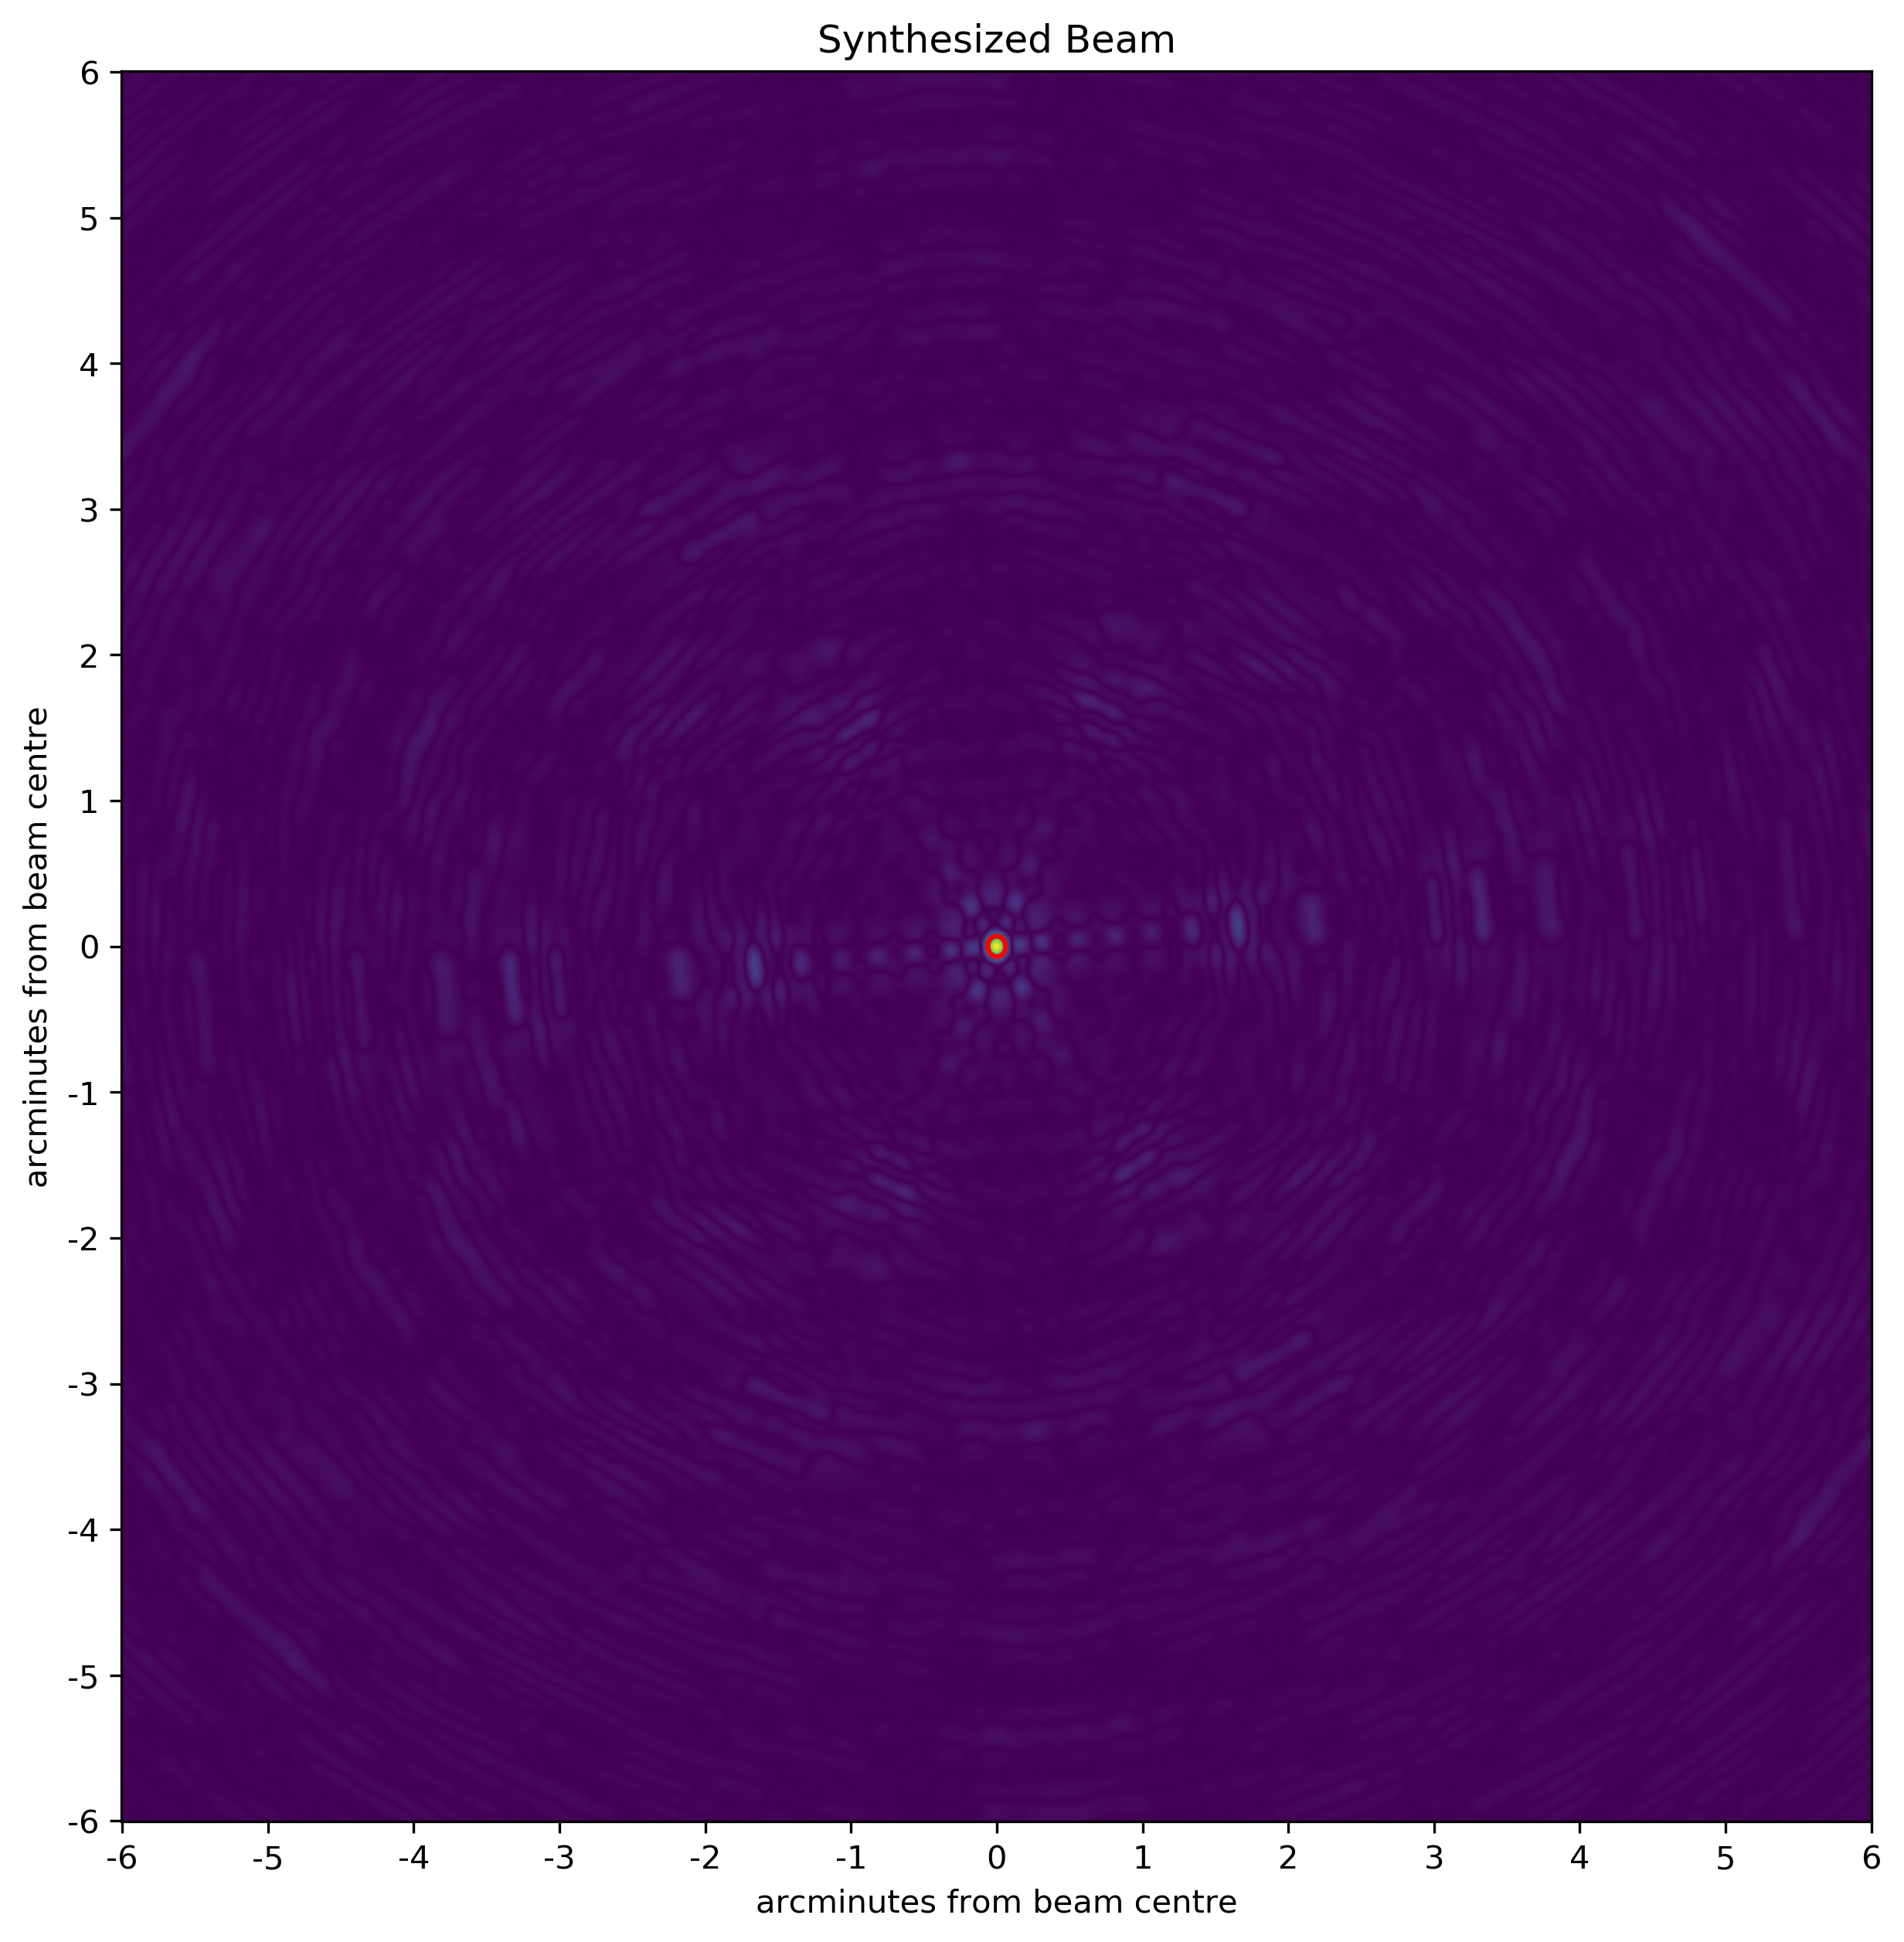

In [23]:
# Plot the synthesized beam and overlay a half-power contour

window = 1/5

# Create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

mid = (hi-lo-1)/2

tickrange = window
tickspace_RA = (window)/12
tickspace_dec = (window)/12
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA_beam  = []
ticklabels_dec_beam = []
for i in range(len(ticks_RA)):
    ticklabels_RA_beam.append(int((ticks_RA[i]-mid)*pixelsize_arcsec/60))
for i in range(len(ticks_dec)):
    ticklabels_dec_beam.append(int((ticks_dec[i]-mid)*pixelsize_arcsec/60))

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(np.abs(dirty_beam)[lo:hi,lo:hi],origin='lower')
plt.contour(np.abs(dirty_beam)[lo:hi,lo:hi],(0,0.5*np.abs(dirty_beam).max()),colors='r')
plt.title('Synthesized Beam')
plt.xlabel('arcminutes from beam centre')
plt.ylabel('arcminutes from beam centre')
plt.xticks(ticks_RA,ticklabels_RA_beam)
plt.yticks(ticks_dec,ticklabels_dec_beam)
plt.show()

###### Fig. 9: The synthesized beam, at the same zoom level as the primary beam diagram in Fig. 4. It is notable how much more spatially contained the peak is, giving us our increased resolution when using interferometric imaging.

To study the synthesized beam more closely, it is helpful to create another plot which is more zoomed in.

Additionally, an ellipse is created which can be fitted to the half-power contour of the beam, allowing us to retrieve its dimensions.

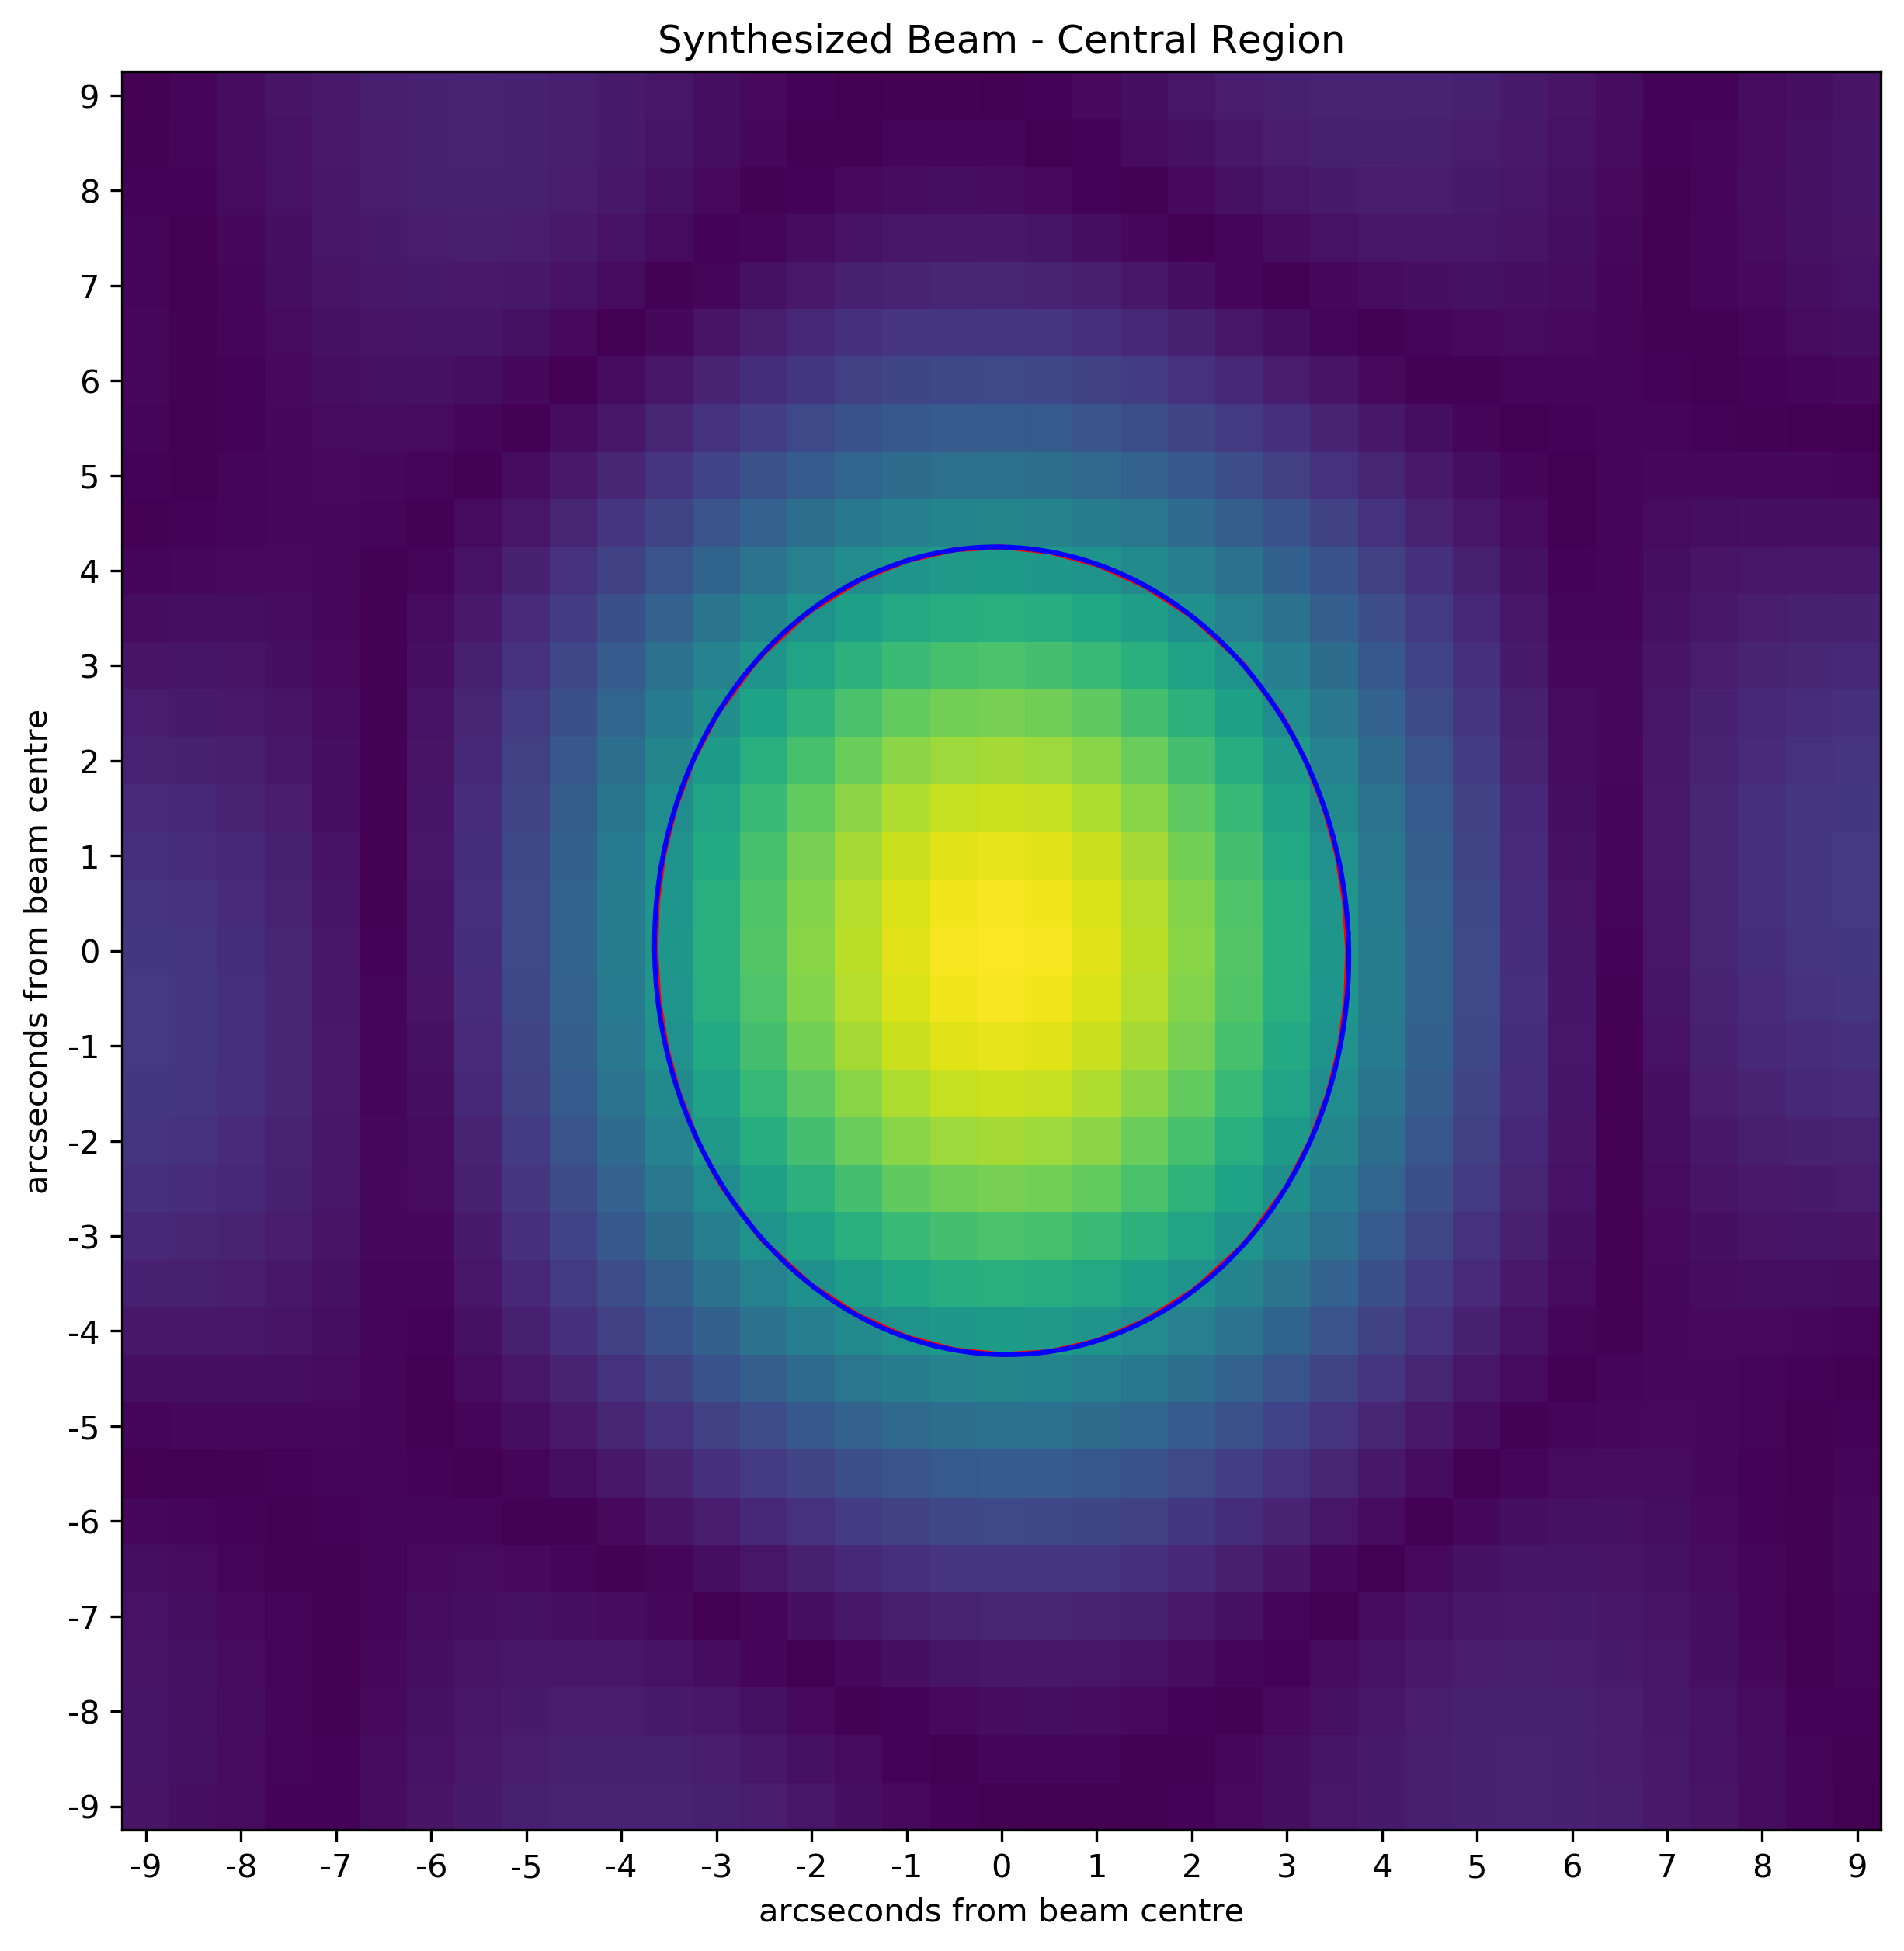

In [24]:
# Create an ellipse to overlay the half-power contour, thus aiding in finding its dimensions

theta = np.arange(0, 2*np.pi, 0.01)
a = 8.5
b = 7.3

xpos = a*np.sin(theta)
ypos = b*np.cos(theta)

# angle phi allows ellipse to be angled

phi = np.pi/2-.05

new_xpos = xpos*np.cos(phi)+ypos*np.sin(phi)
new_ypos = -xpos*np.sin(phi)+ypos*np.cos(phi)

# Plot the synthesized beam and overlay a half-power contour, zoomed in for clarity
# The pixel size is the same as in the original field image

window = 0.005

# Create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

mid = (hi-lo-1)/2

tickrange = window
tickspace_RA = (window)/18
tickspace_dec = (window)/18
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA_beam  = []
ticklabels_dec_beam = []
for i in range(len(ticks_RA)):
    ticklabels_RA_beam.append(int((ticks_RA[i]-mid)*pixelsize_arcsec))
for i in range(len(ticks_dec)):
    ticklabels_dec_beam.append(int((ticks_dec[i]-mid)*pixelsize_arcsec))

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(np.abs(dirty_beam)[lo:hi,lo:hi],origin='lower')
plt.contour(np.abs(dirty_beam)[lo:hi,lo:hi],(0,0.5*abs(dirty_beam).max()),colors='r')
plt.plot((new_xpos+(hi-lo-1)/2), (new_ypos+(hi-lo-1)/2), 'b-')
plt.title('Synthesized Beam - Central Region')
plt.xlabel('arcseconds from beam centre')
plt.ylabel('arcseconds from beam centre')
plt.xticks(ticks_RA,ticklabels_RA_beam)
plt.yticks(ticks_dec,ticklabels_dec_beam)
plt.show()

###### Fig. 10: A closeup of the central region of the synthesized beam, where the response peak is located. By varying the two parameters until the blue ellipse completely overlaps the half-power contour, we find a major axis of ~8.5 arcseconds and s minor axis of ~7.3 arcseconds.


***


# 9. Producing an Image

Initially, the observed response function is calculated. The response function is only sampled where the array provides UV coverage, so the sampled response function is the multiplication of the UV coverage array and the complete response function:

In [25]:
R_obs = uv_tracks * ftsky

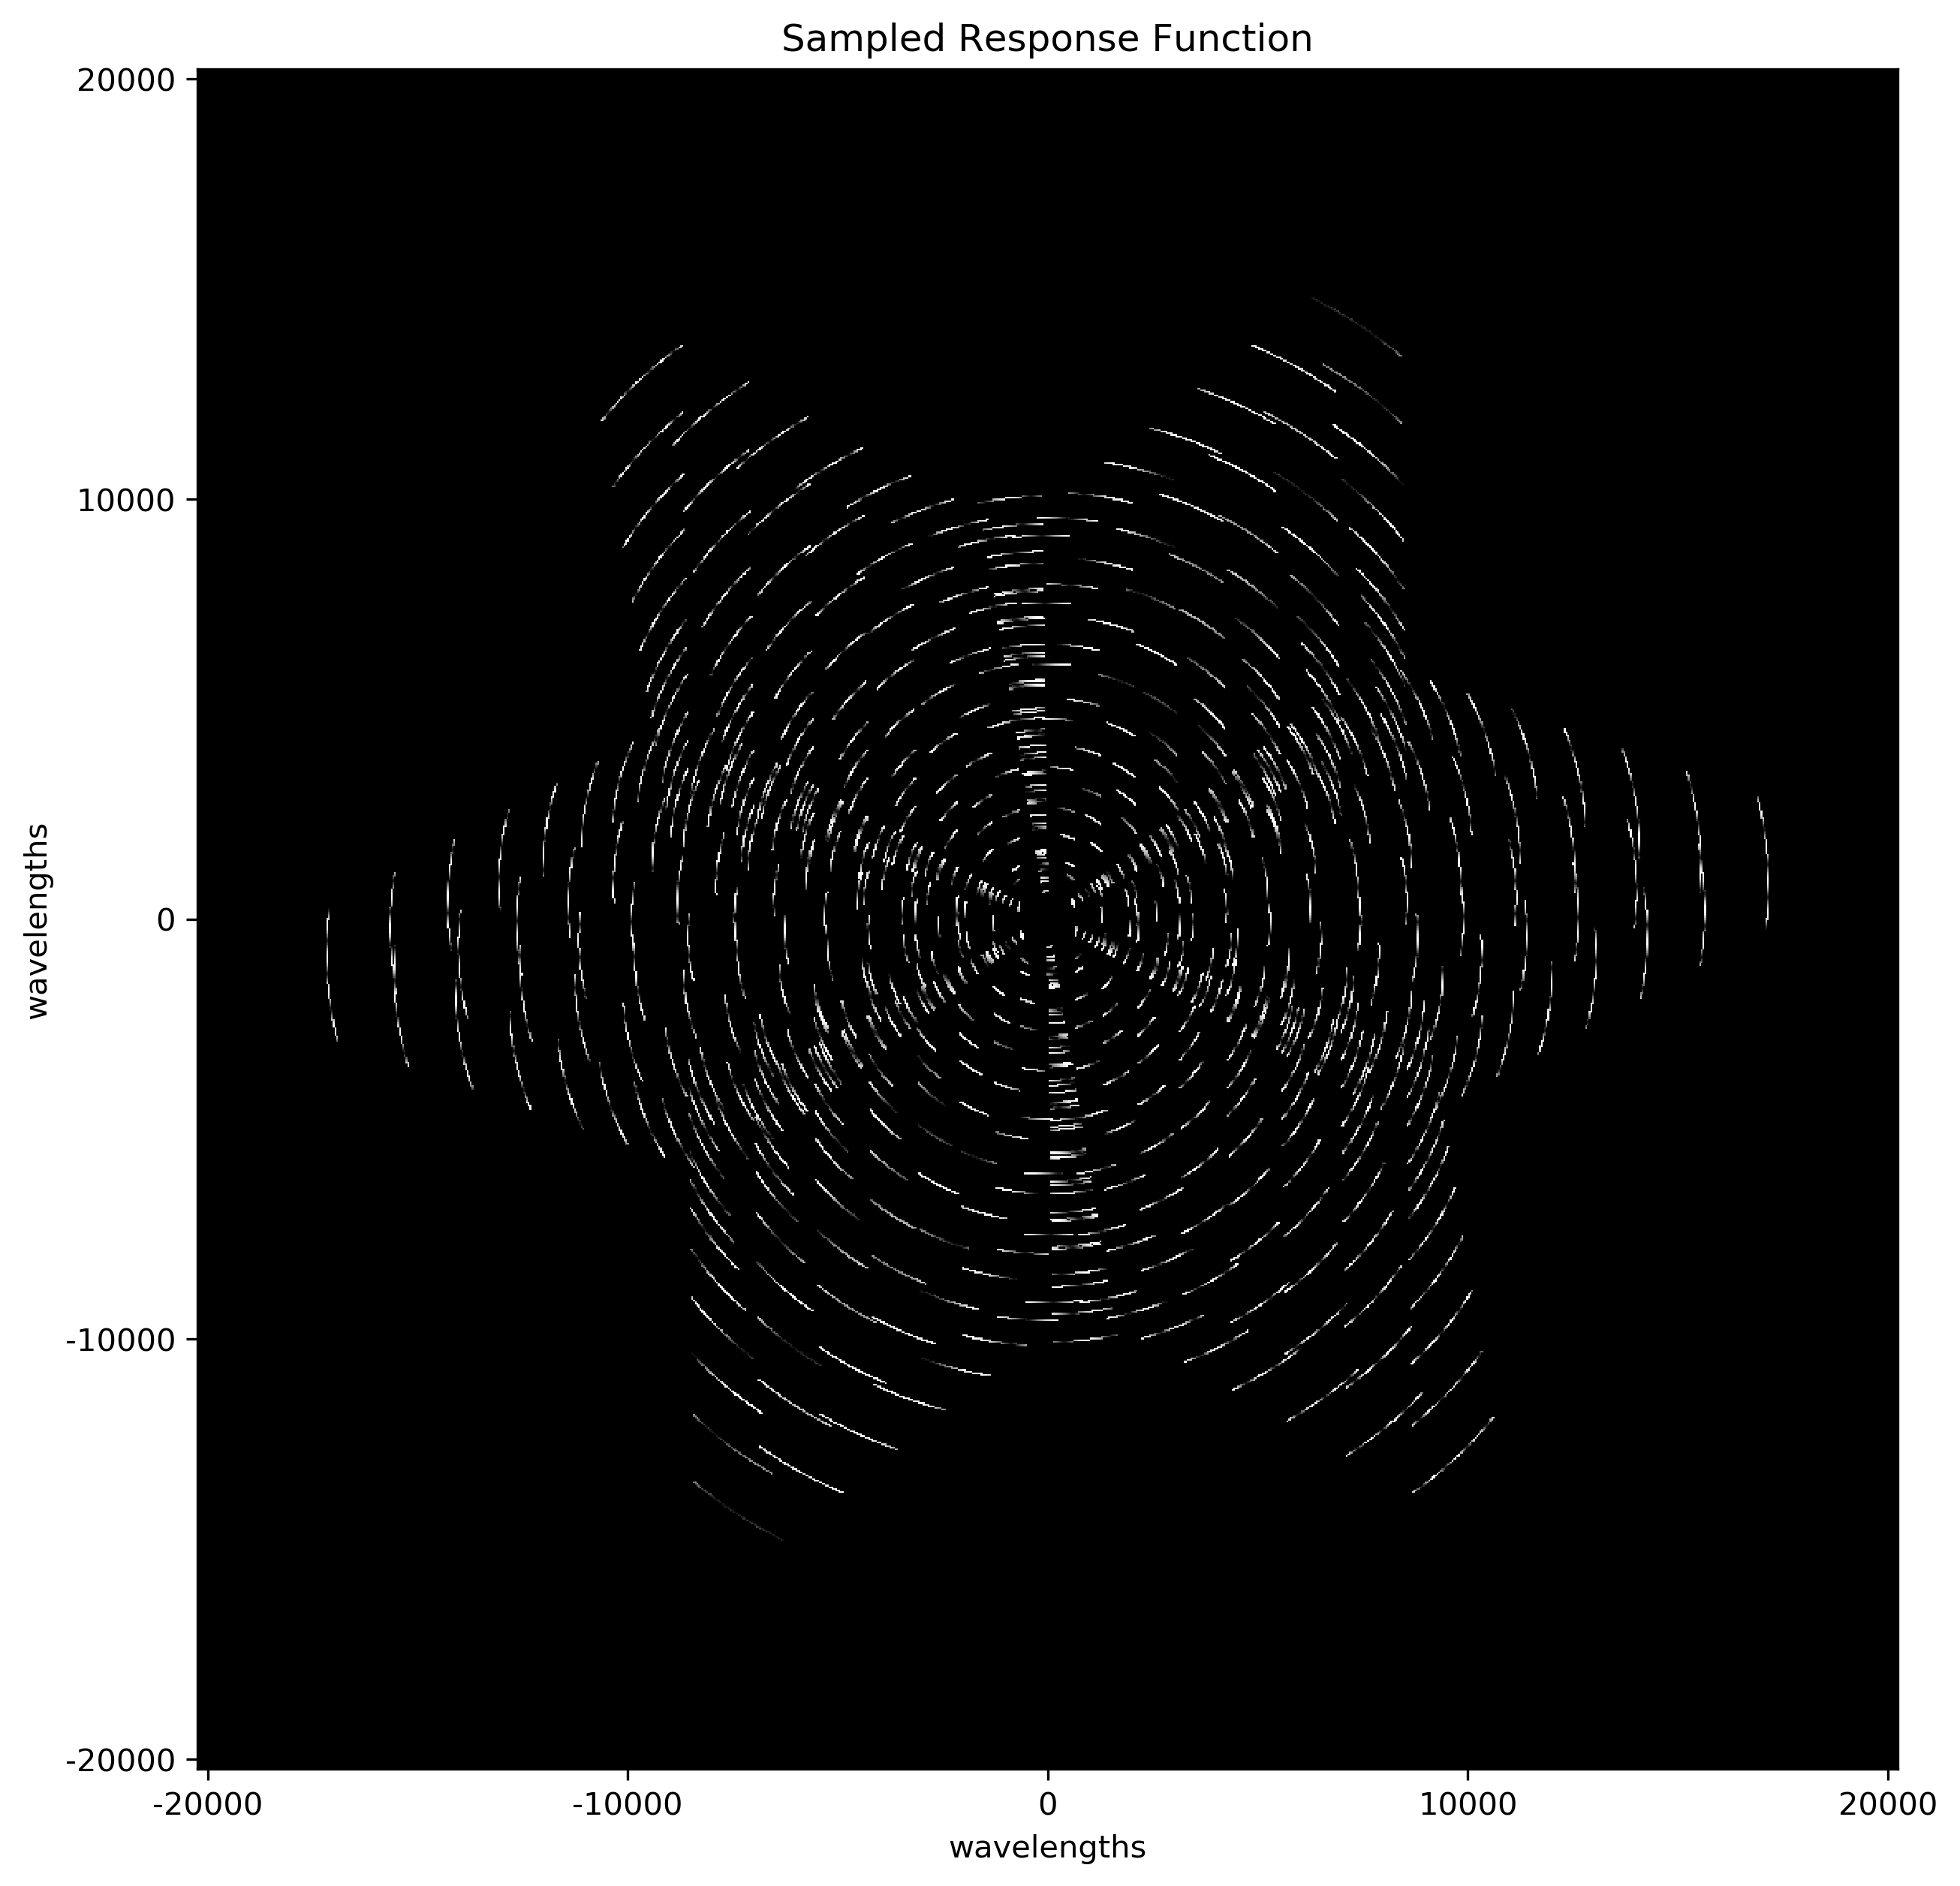

In [26]:
# for greater readability, define zoomed-in area of plot as a fraction (in each dimension) of the larger image

window = 1/7

# create array boundaries based on the size of the zoomed-in area

window = int((dims)*window)
lo = int((dims)/2 - window/2)
hi = int((dims)/2 + window/2)+1

mid = int(round((hi-lo)/2))

wvln_step = 10000
ticks_uv = np.arange(0,mid+1,wvln_step/39.33)
ticks_uv = list(dict.fromkeys(np.concatenate((-np.flip(ticks_uv),ticks_uv))))

ticklabels_uv = []
for i in range(len(ticks_uv)):
    ticklabels_uv.append(np.int(ticks_uv[i]*39.33))

for i in range(len(ticks_uv)):
    ticks_uv[i] += mid

R_obs = uv_tracks * ftsky

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(np.abs(R_obs)[lo:hi,lo:hi],cmap='gray',origin='lower')
plt.title('Sampled Response Function')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.xticks(ticks_uv,ticklabels_uv)
plt.yticks(ticks_uv,ticklabels_uv)
plt.show()

###### Fig. 11: The response function as sampled by the UV tracks. The stripes of the response function (seen in Fig. 6) are somewhat visible but have been sampled coarsely by the interferometer.

Now, the synthesized interferometer image is the inverse Fourier transform of the sampled response function.

The Convolution theorem (http://mathworld.wolfram.com/ConvolutionTheorem.html) gives us that:

$$ FT[ f(x,y)*g(x,y) ] = \tilde{f}(u,v) \times \tilde{g}(u,v) $$

Where $\tilde{f}(u,v) = FT[ f(x,y) ]$.

So, having multiplied the Fourier transform of the sky and our UV coverage map above, the reverse Fourier transform of our result is the convolution of our synthesized beam and the input sky array:

In [27]:
image_obs = ift(R_obs)

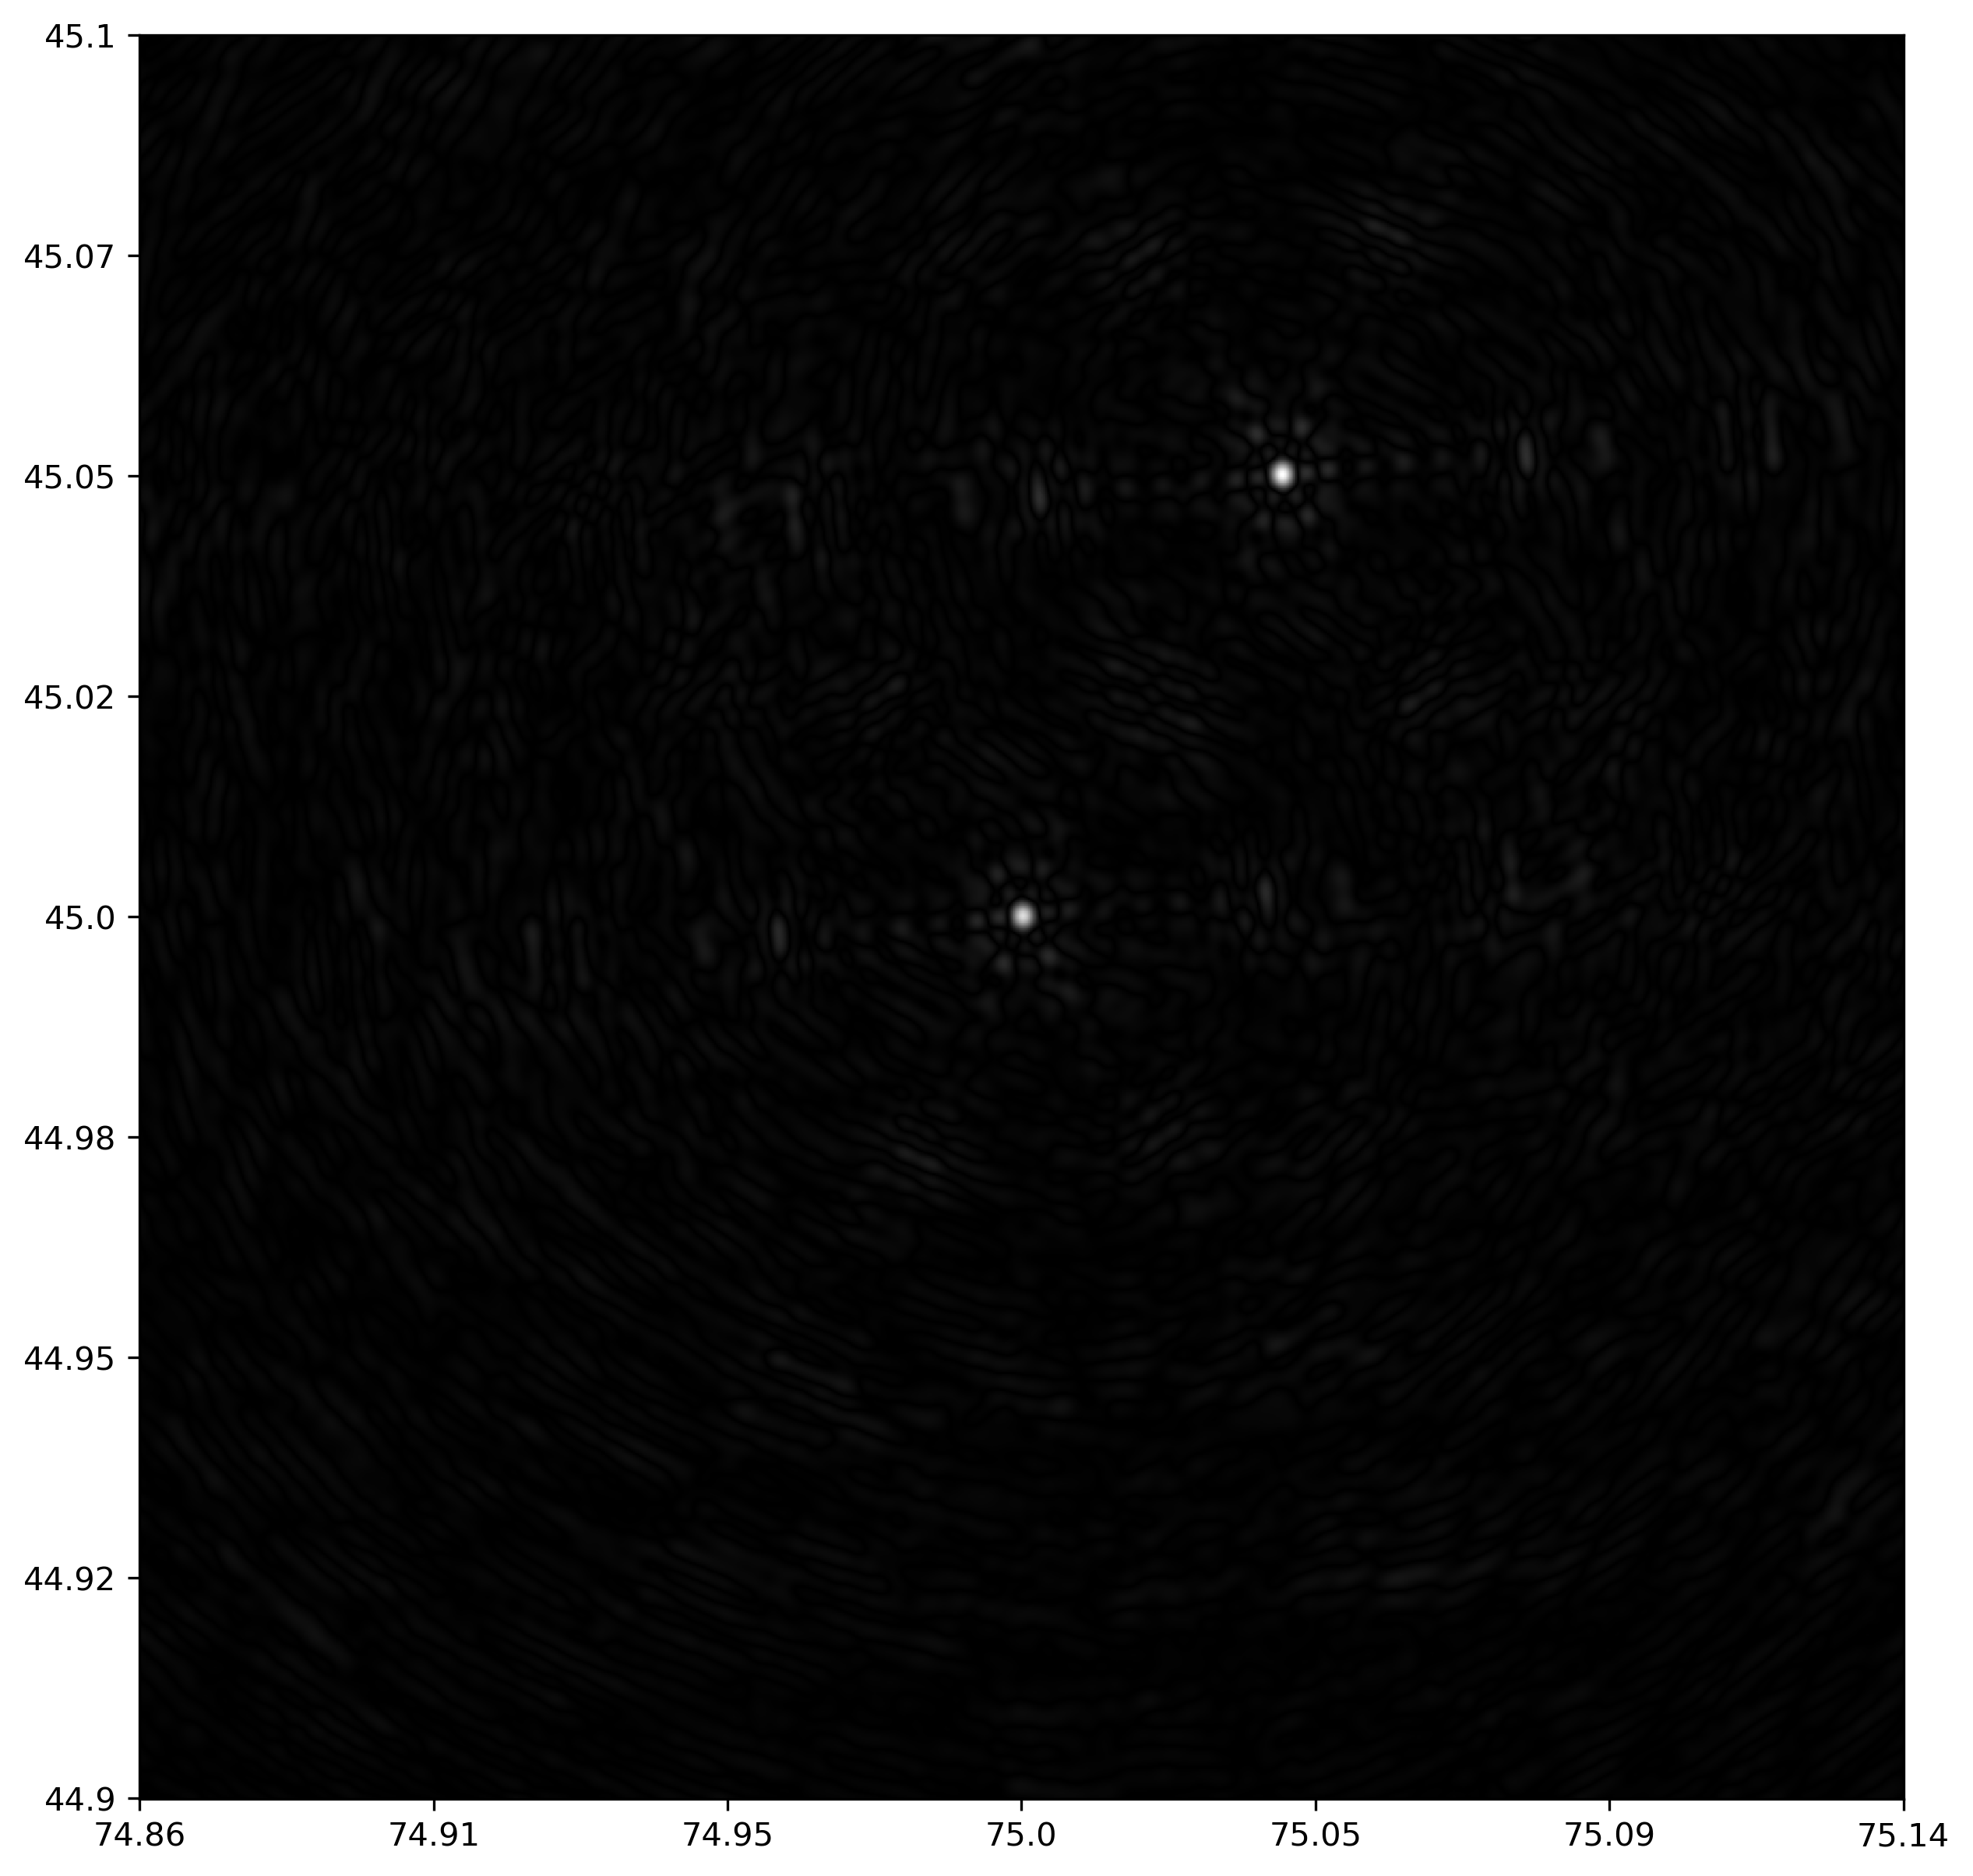

In [28]:
window = 1/5

window = int((dims-1)*window)
lo = int((dims-1)/2 - window/2)
hi = int((dims-1)/2 + window/2)

plt.figure(figsize=(10,10),dpi=300)
tickrange = window
tickspace_RA = (window)/6
tickspace_dec = (window)/8
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA  = []
ticklabels_dec = []
for i in range(len(ticks_RA)):
    ticklabels_RA.append(round(RA[lo+int(np.round(ticks_RA[i]))],2))
for i in range(len(ticks_dec)):
    ticklabels_dec.append(round(dec[lo+int(np.round(ticks_dec[i]))],2))
plt.imshow(np.abs(image_obs)[lo:hi,lo:hi],cmap='gray',origin='lower')
plt.xticks(ticks_RA,ticklabels_RA)
plt.yticks(ticks_dec,ticklabels_dec)
plt.show()

maximum = np.max(np.abs(image_obs))

###### Fig. 12: The image of the sky produced by the interferometer.


***


# 10. Measurement

In [29]:
loc1 = [3600,3600]
loc2 = np.argwhere(np.abs(image_obs) == maximum)[0]

In [30]:
print('Location of Source 1:')
print('RA   = ',np.int(np.round(RA[loc1[1]]/15)),'hours,',np.int(np.round(RA[loc1[1]]/15%1*60)),'minutes,',np.int(np.round((RA[loc1[1]]/15%1*60)%1*60)),'seconds')
print('dec  = ',np.int(dec[loc1[0]]),'degrees,',np.int(np.round((dec[loc1[0]]%1)*60,3)),'arcmin,',np.int(np.round((dec[loc1[0]]%1)*60,3)%1),'arcsec')
print()
print('Location of Source 2:')
print('RA   = ',np.int(np.round(RA[loc2[1]]/15)),'hours,',np.int(np.round(RA[loc2[1]]/15%1*60)),'minutes,',np.int(np.round((RA[loc2[1]]/15%1*60)%1*60)),'seconds')
print('dec  = ',np.int(dec[loc2[0]]),'degrees,',np.int(np.round((dec[loc2[0]]%1)*60,3)),'arcmin,',np.int(np.round((dec[loc2[0]]%1)*60,3)%1),'arcsec')

Location of Source 1:
RA   =  5 hours, 0 minutes, 0 seconds
dec  =  45 degrees, 0 arcmin, 0 arcsec

Location of Source 2:
RA   =  5 hours, 0 minutes, 10 seconds
dec  =  45 degrees, 3 arcmin, 0 arcsec


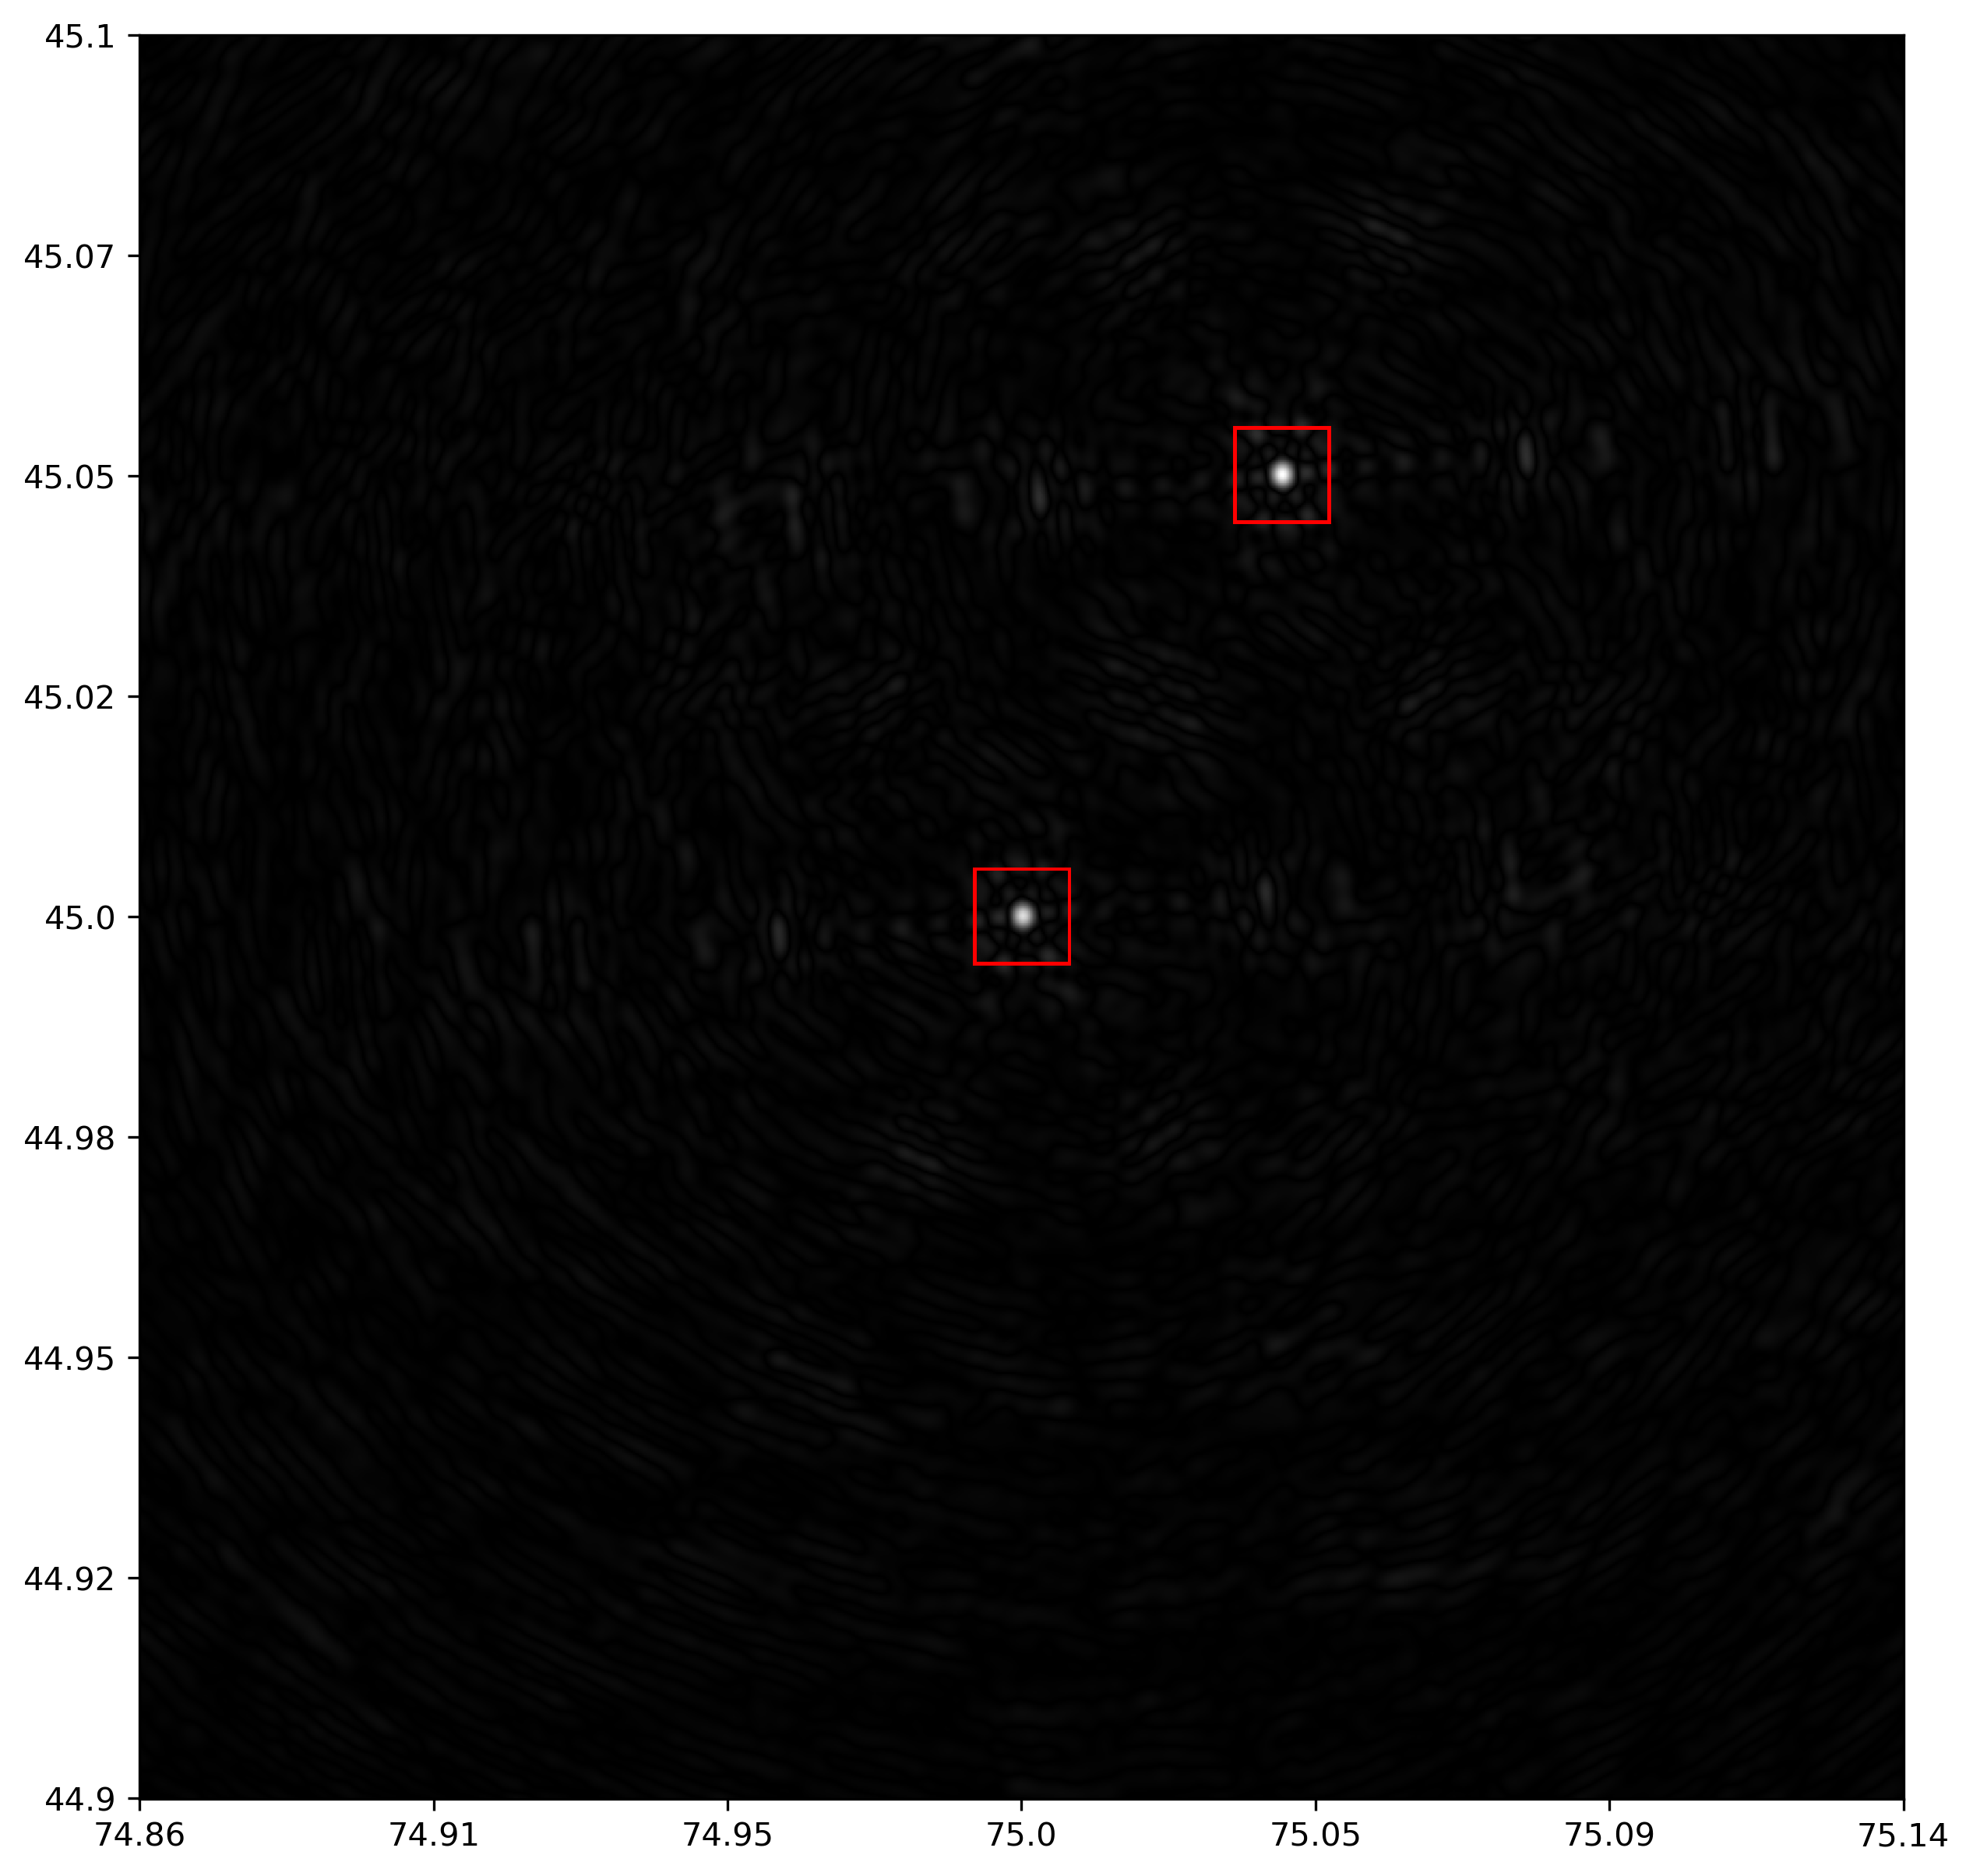

In [31]:
# create masks

overlay = np.zeros_like(np.abs(image_obs))

ws = 40

overlay[loc1[0]-ws:loc1[0]+ws,loc1[1]-ws:loc1[1]+ws] = 1
overlay[loc2[0]-ws:loc2[0]+ws,loc2[1]-ws:loc2[1]+ws] = 1

overlay_exit = np.copy(overlay)

overlay[loc1[0]-(ws-3):loc1[0]+(ws-3),loc1[1]-(ws-3):loc1[1]+(ws-3)] = 0
overlay[loc2[0]-(ws-3):loc2[0]+(ws-3),loc2[1]-(ws-3):loc2[1]+(ws-3)] = 0

overlay2 = np.empty_like(overlay)
overlay2 = np.where(overlay == 0, np.nan, overlay)

# plot field with masks overlaid

window = 1/5

window = int((dims-1)*window)
lo = int((dims-1)/2 - window/2)
hi = int((dims-1)/2 + window/2)

tickrange = window
tickspace_RA = (window)/6
tickspace_dec = (window)/8
ticks_RA = np.arange(0,window+1,tickspace_RA)
ticks_dec = np.arange(0,window+1,tickspace_dec)
ticklabels_RA  = []
ticklabels_dec = []
for i in range(len(ticks_RA)):
    ticklabels_RA.append(round(RA[lo+int(np.round(ticks_RA[i]))],2))
for i in range(len(ticks_dec)):
    ticklabels_dec.append(round(dec[lo+int(np.round(ticks_dec[i]))],2))

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(np.abs(image_obs)[lo:hi,lo:hi],cmap='gray',origin='lower')
plt.imshow(overlay2[lo:hi,lo:hi],cmap='hsv',origin='lower')
plt.xticks(ticks_RA,ticklabels_RA)
plt.yticks(ticks_dec,ticklabels_dec)
plt.show()

To isolate the peaks of the image, I first applied a mask to retrieve only 'noise' and found the standard deviation:

In [32]:
# apply masks to point sources to accurately find standard deviation of beam noise

image_masked = np.copy(image_obs)

ws = 40

image_masked[loc1[0]-ws:loc1[0]+ws,loc1[1]-ws:loc1[1]+ws] = 0
image_masked[loc2[0]-ws:loc2[0]+ws,loc2[1]-ws:loc2[1]+ws] = 0

In [33]:
# find standard deviation of 'noise'

stdev = np.std(np.abs(image_masked))

This can be used in a filter to mask all pixels below a certain value. This was optimised so that the ratio of the signals from each source was the same as the two original point sources.

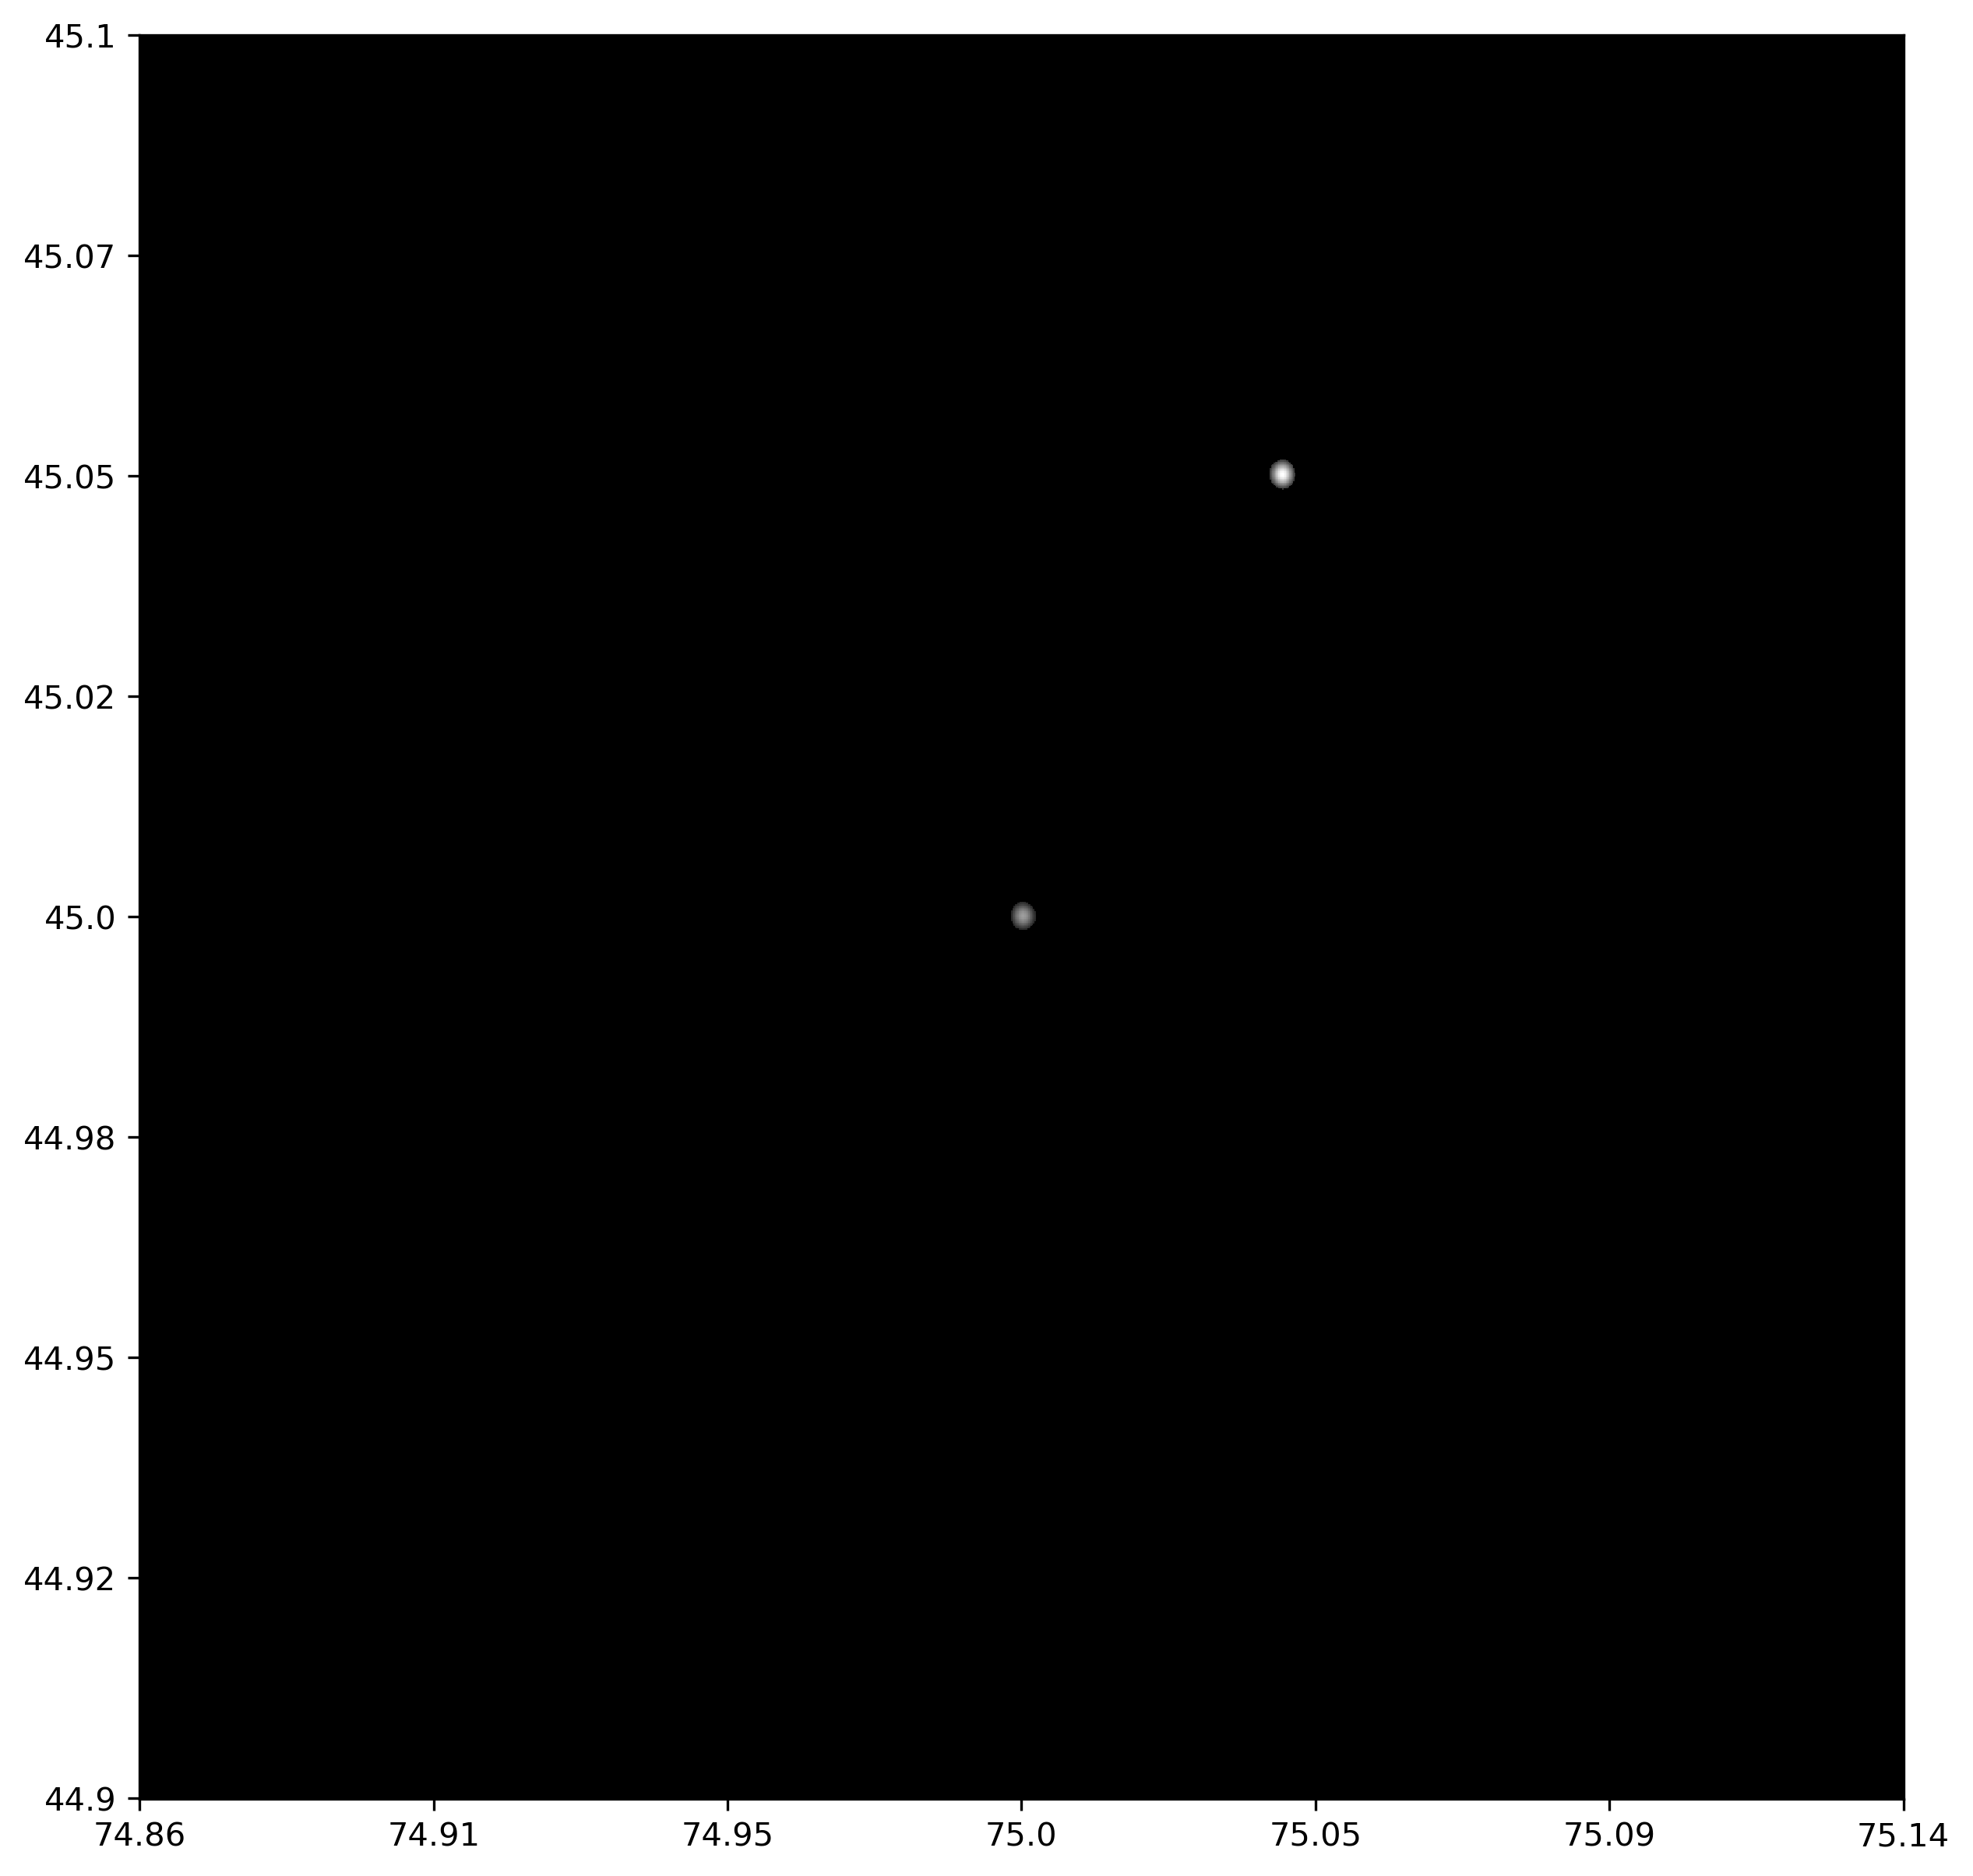

In [34]:
src_iso = np.abs(np.copy(image_obs))

src_iso[src_iso < (33*stdev)] = 0

src_iso = src_iso/primary_beam

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(src_iso[lo:hi,lo:hi],cmap='gray',origin='lower')
plt.xticks(ticks_RA,ticklabels_RA)
plt.yticks(ticks_dec,ticklabels_dec)
plt.show()

In [35]:
# get each point source from larger array

src1 = src_iso[loc1[0]-ws:loc1[0]+ws,loc1[1]-ws:loc1[1]+ws]
src2 = src_iso[loc2[0]-ws:loc2[0]+ws,loc2[1]-ws:loc2[1]+ws]

src1_signal = np.sum(src1)
src2_signal = np.sum(src2)

print(src2_signal,src1_signal)
print(src2_signal*11.5,src1_signal*11.5)
print()
print(src2_signal/src1_signal)
print(5.8/3.6)

0.5133929574522766 0.3089014034213033
5.904019010701181 3.5523661393449877

1.6619961960874363
1.611111111111111


The ratio between the two source brightnesses is approximately the same, but the actual signal is roughly 11.5 times less than the input fluxes. With more time, I would be able to work out the conversion factors when performing Fourier operations, to hopefully retrieve a final image scaled to the same level as the original sky.


***


# 11. Further Work

With more time available, I would implement a CLEAN algorithm to deconvolve the image, thus the sources would be better resolved and the image would look more like the real sky.